<a href="https://colab.research.google.com/github/Jepees/CNN_CIFAR-10/blob/main/UTS_Deep%20Learning_Classification%20CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tugas UTS: Kelompok
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Dataset: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

Tutorial: [CIFAR-10 on PyTorch](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

Buatlah model Neural Networks yang dapat mengklasifikasikan 10 kelas dari dataset tersebut.

Tugas:
* Membandingkan hasil evaluasi CNNs dengan AlexNet, VGG, ResNet (pilih salah satu).
* Menginterpretasikan setiap line code dengan jelas (tidak perlu rinci).
* Melakukan optimasi hyperparameter dan teknik lain untuk meningkatkan akurasi.
* Melakukan analisis feature maps untuk melihat kesalahan prediksi dari model.

Tagihan: Slide Presentasi, Notebooks(colab/jupyter).

| Nama    | NIM    |
| -------- | ---------- |
| Dani Hidayat      | 11220940000014    |
| Muhammad Abdul Ghofur  | 11220940000020     |


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import re
import math

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


plt.style.use('default')

In [ ]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(123)

# Load Dataset dan Normalisasi

In [ ]:
# Device COnfiguration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameter
num_epochs = 30
batch_size = 32
learning_rate = 0.001

In [ ]:
# Transformasi data

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation: random flip
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize as per notebook
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load full training set
full_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split jadi train dan validation
train_size = int(0.8 * len(full_trainset))  # 80% untuk train
val_size = len(full_trainset) - train_size  # 20% untuk validasi
trainset, valset = random_split(full_trainset, [train_size, val_size])

# DataLoader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

# Test set (tetap seperti biasa)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Kelas
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
# Checking the dataset
print('Training Set:')
for images, labels in trainloader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valloader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in testloader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:
Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])
tensor([5, 3, 6, 5, 9, 4, 7, 2, 6, 8])

Validation Set:
Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])
tensor([4, 9, 5, 2, 8, 4, 1, 1, 7, 2])

Testing Set:
Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])


# Visualisasi dataset

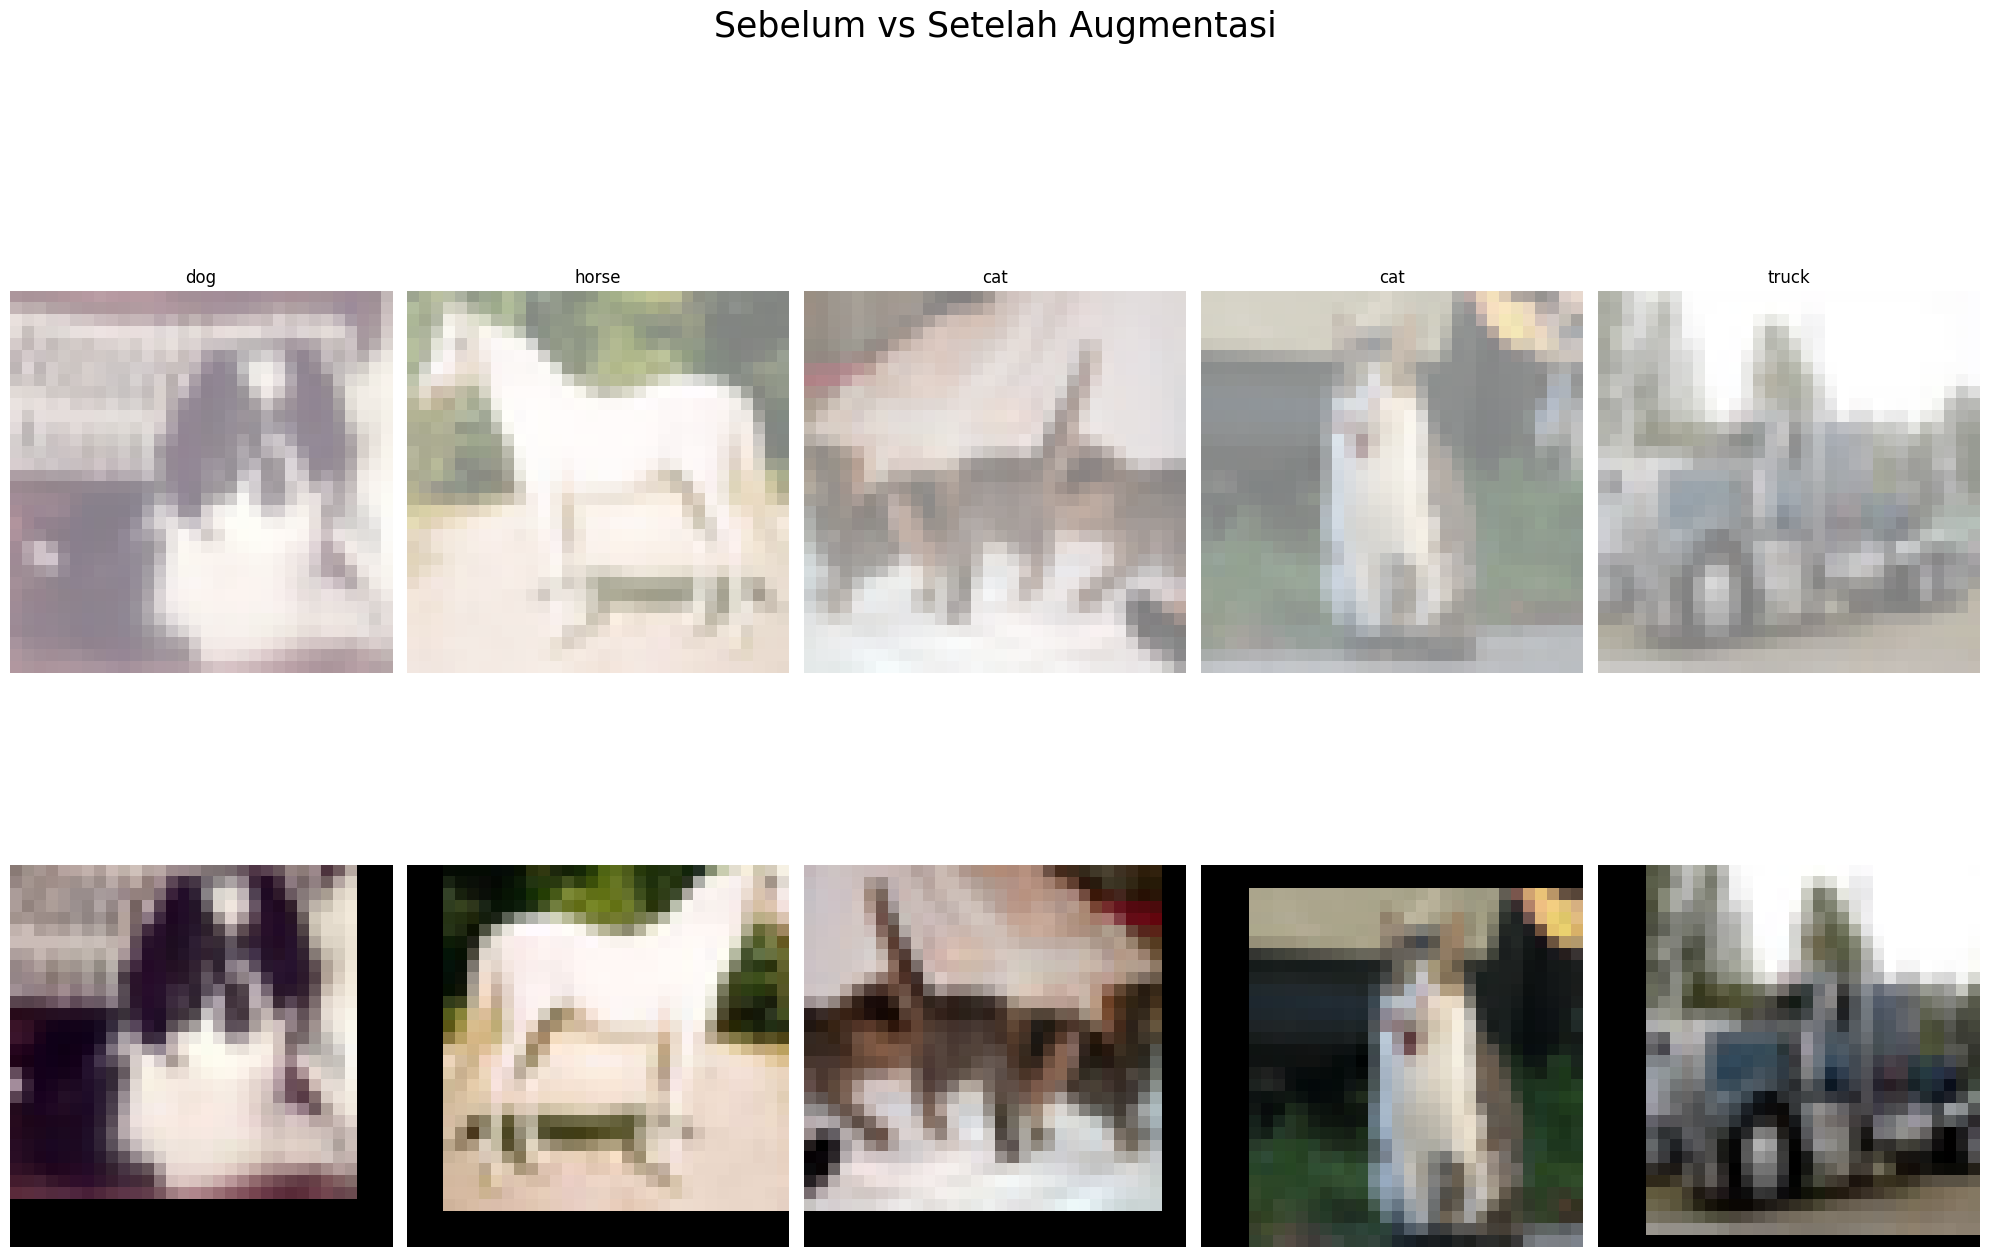

In [ ]:
# Transformasi "sebelum" (tanpa augmentasi)
transform_plain = transforms.ToTensor()

# Transformasi "setelah" (dengan augmentasi)
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset asli tanpa transformasi
raw_dataset = datasets.CIFAR10(root='./data', train=True, download=True)

# Ambil 10 indeks acak
random_indices = random.sample(range(len(raw_dataset)), 5)

# Plot gambar
fig, axes = plt.subplots(2, 5, figsize=(20, 15))
fig.suptitle("Sebelum vs Setelah Augmentasi", fontsize=25)

for i, idx in enumerate(random_indices):
    # Ambil gambar dan label (PIL image)
    img, label = raw_dataset[idx]

    # Sebelum: langsung toTensor tanpa augmentasi
    plain_img = transform_plain(img)

    # Sesudah: augmentasi penuh
    augmented_img = transform_augmented(img)

    # Fungsi bantu untuk convert tensor ke image (normalize inverse)
    def imshow(tensor_img):
        tensor_img = tensor_img.clone().detach()
        tensor_img = tensor_img * 0.5 + 0.5  # unnormalize
        npimg = tensor_img.numpy()
        return np.transpose(npimg, (1, 2, 0))  # CHW -> HWC

    # Plot sebelum augmentasi
    axes[0, i].imshow(imshow(plain_img))
    axes[0, i].set_title(classes[label])
    axes[0, i].axis('off')

    # Plot sesudah augmentasi
    axes[1, i].imshow(imshow(augmented_img))
    # axes[1, i].set_title("Setelah Augmentasi")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


# Arsitektur Model-Model

In [ ]:
class alexNet(nn.Module):
    def __init__(self):
        super(alexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),           # Conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                          # MaxPool1

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),         # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                          # MaxPool2

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),        # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),        # Conv4
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),        # Conv5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)                           # MaxPool5
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 1024),  # FC6
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),          # FC7
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),            # FC8
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)          # flatten
        x = self.classifier(x)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # (3, 32, 32) -> (32, 32, 32)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # (32, 32, 32) -> (64, 32, 32)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),          # -> (64, 16, 16)
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # -> (128, 16, 16)
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),          # -> (128, 8, 8)
            nn.Dropout(0.5),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                   # -> (128 * 8 * 8)
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        # x = x.view(x.size(0), -1)          # flatten
        x = self.classifier(x)
        return x

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Funtions

In [ ]:
#FUNCTIONS

#Training Functiom
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=10, patience=5, PATH='model.pth'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    trigger_times = 0
    early_stopped = False

    # Mulai timer
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(valloader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), PATH)
            print(f'Validation loss improved. Model saved to {PATH}')
        else:
            trigger_times += 1
            print(f'No improvement. Early stopping trigger: {trigger_times}/{patience}')
            if trigger_times >= patience:
                print('Early stopping activated.')
                early_stopped = True
                break


    # Selesai timer
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    print(f'Training complete in {minutes}m {seconds}s')

    return model, train_losses, val_losses, train_accuracies, val_accuracies, best_val_loss, epoch+1, early_stopped

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Function Plot Accuracy and Loss in Training and Validation
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 7))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Function Evaluation Model
def evaluate_model(model, testloader, device, classes):
    model.eval()  # pastikan model dalam eval mode
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(len(classes))]
    n_class_samples = [0 for _ in range(len(classes))]

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for label, pred in zip(labels, predicted):
                if label == pred:
                    n_class_correct[label.item()] += 1
                n_class_samples[label.item()] += 1

    overall_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy model {str(model)[:str(model).index("(")]} on the {n_samples} test images: {overall_acc:.2f}%')

    for i in range(len(classes)):
        if n_class_samples[i] > 0:
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {class_acc:.2f}%')
        else:
            print(f'Accuracy of {classes[i]}: N/A (no samples)')
    print('\n')

    # return overall_acc, n_class_correct, n_class_samples

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Plot Confusion Matrix Function
def plot_confusion_matrix(model, testloader, device, class_names, model_path=None):
    if model_path is not None:
        model.load_state_dict(torch.load(model_path))
        print(f"Model loaded from {model_path}")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Hitung confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Visualisasi
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {str(model)[:str(model).index("(")]} - CIFAR-10')
    plt.tight_layout()
    plt.show()

    # return cm

    print(pd.Series({
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision (macro)': precision_score(all_labels, all_preds, average='macro', zero_division=0),
        'Recall (macro)': recall_score(all_labels, all_preds, average='macro', zero_division=0),
        'F1 Score (macro)': f1_score(all_labels, all_preds, average='macro', zero_division=0)
    }))



In [ ]:
PATH_alex = './Fix Model/AlexCifar.pth'
PATH_CNN1 = './Fix Model/CNNCifar.pth'
PATH_CNNNew = './Fix Model/CNNNew.pth'

# Training Process

In [ ]:
AlexNet = alexNet().to(device)

criterion_alex = nn.CrossEntropyLoss()
optimizer_alex = optim.Adam(AlexNet.parameters(), lr=learning_rate)

#model path
PATH_alex = './Fix Model/AlexCifar.pth'

AlexNet, train_losses_Alex, val_losses_Alex, train_accuracies_Alex, val_accuracies_Alex, best_val_loss_Alex, epoch_Alex, early_stopped_Alex = train_model(AlexNet, trainloader, valloader, criterion_alex, optimizer_alex, device, num_epochs=num_epochs, patience=5, PATH=PATH_alex)

Epoch [1/30] Train Loss: 1.7701, Train Acc: 0.3272 | Val Loss: 1.4472, Val Acc: 0.4606
Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth
Epoch [2/30] Train Loss: 1.4202, Train Acc: 0.4781 | Val Loss: 1.2961, Val Acc: 0.5127
Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth
Epoch [3/30] Train Loss: 1.2660, Train Acc: 0.5443 | Val Loss: 1.1351, Val Acc: 0.5935
Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth
Epoch [4/30] Train Loss: 1.1479, Train Acc: 0.5914 | Val Loss: 1.1164, Val Acc: 0.6005
Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth
Epoch [5/30] Train Loss: 1.0698, Train Acc: 0.6257 | Val Loss: 0.9998, Val Acc: 0.6508
Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth
Epoch [6/30] Train Loss: 1.0201, Train Acc: 0.6440 | Val Loss: 0.9940, Val Acc: 0.6536
Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth
Epoch [7/30] Train Loss: 0.9595, Train Acc: 0.6663 | Val Loss: 0.9381, Val A

In [ ]:
CNNCifar = CNN().to(device)

criterion_CNN = nn.CrossEntropyLoss()
optimizer_CNN = optim.Adam(CNNCifar.parameters(), lr=learning_rate)

#model path
PATH_CNN1 = './Fix Model/CNNCifar.pth'

CNNCifar, train_losses_CNN, val_losses_CNN, train_accuracies_CNN, val_accuracies_CNN, best_val_loss_CNN, epoch_CNN, early_stopped_CNN = train_model(CNNCifar, trainloader, valloader, criterion_CNN, optimizer_CNN, device, num_epochs=num_epochs, patience=5, PATH=PATH_CNN1)

Epoch [1/30] Train Loss: 1.9248, Train Acc: 0.2598 | Val Loss: 1.6808, Val Acc: 0.3587
Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth
Epoch [2/30] Train Loss: 1.7484, Train Acc: 0.3248 | Val Loss: 1.5156, Val Acc: 0.4620
Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth
Epoch [3/30] Train Loss: 1.6756, Train Acc: 0.3595 | Val Loss: 1.4342, Val Acc: 0.4709
Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth
Epoch [4/30] Train Loss: 1.6173, Train Acc: 0.3805 | Val Loss: 1.4071, Val Acc: 0.4963
Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth
Epoch [5/30] Train Loss: 1.5779, Train Acc: 0.3993 | Val Loss: 1.2869, Val Acc: 0.5522
Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth
Epoch [6/30] Train Loss: 1.5402, Train Acc: 0.4176 | Val Loss: 1.2884, Val Acc: 0.5552
No improvement. Early stopping trigger: 1/5
Epoch [7/30] Train Loss: 1.5157, Train Acc: 0.4241 | Val Loss: 1.2459, Val Acc: 0.5657
Validation loss i

In [ ]:
CNNNew = CNN2().to(device)

criterion_CNNNew = nn.CrossEntropyLoss()
optimizer_CNNNew = optim.Adam(CNNNew.parameters(), lr=learning_rate)

#model path
PATH_CNNNew = './Fix Model/CNNNew.pth'

CNNNew, train_losses_CNNNew, val_losses_CNNNew, train_accuracies_CNNNew, val_accuracies_CNNNew, best_val_loss_CNNNew, epoch_CNNNew, early_stopped_CNNNew = train_model(CNNNew, trainloader, valloader, criterion_CNNNew, optimizer_CNNNew, device, num_epochs=num_epochs, patience=5, PATH=PATH_CNNNew)

Epoch [1/30] Train Loss: 1.7010, Train Acc: 0.3718 | Val Loss: 1.3568, Val Acc: 0.4966
Validation loss improved. Model saved to ./Fix Model/CNNNew.pth
Epoch [2/30] Train Loss: 1.3870, Train Acc: 0.4961 | Val Loss: 1.2587, Val Acc: 0.5466
Validation loss improved. Model saved to ./Fix Model/CNNNew.pth
Epoch [3/30] Train Loss: 1.2357, Train Acc: 0.5572 | Val Loss: 1.1312, Val Acc: 0.6058
Validation loss improved. Model saved to ./Fix Model/CNNNew.pth
Epoch [4/30] Train Loss: 1.1256, Train Acc: 0.6020 | Val Loss: 0.9806, Val Acc: 0.6493
Validation loss improved. Model saved to ./Fix Model/CNNNew.pth
Epoch [5/30] Train Loss: 1.0464, Train Acc: 0.6357 | Val Loss: 0.8857, Val Acc: 0.6863
Validation loss improved. Model saved to ./Fix Model/CNNNew.pth
Epoch [6/30] Train Loss: 0.9728, Train Acc: 0.6609 | Val Loss: 0.8468, Val Acc: 0.6969
Validation loss improved. Model saved to ./Fix Model/CNNNew.pth
Epoch [7/30] Train Loss: 0.9170, Train Acc: 0.6819 | Val Loss: 0.7866, Val Acc: 0.7249
Validat

# Evaluasi Model


In [ ]:
AlexNet = alexNet()
AlexNet.load_state_dict(torch.load(PATH_alex))

CNNCifar = CNN()
CNNCifar.load_state_dict(torch.load(PATH_CNN1))

CNNNew = CNN2()
CNNNew.load_state_dict(torch.load(PATH_CNNNew))


<All keys matched successfully>

In [ ]:
AlexNet_Log = ["Epoch [1/30] Train Loss: 1.7701, Train Acc: 0.3272 | Val Loss: 1.4472, Val Acc: 0.4606",
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [2/30] Train Loss: 1.4202, Train Acc: 0.4781 | Val Loss: 1.2961, Val Acc: 0.5127',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [3/30] Train Loss: 1.2660, Train Acc: 0.5443 | Val Loss: 1.1351, Val Acc: 0.5935',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [4/30] Train Loss: 1.1479, Train Acc: 0.5914 | Val Loss: 1.1164, Val Acc: 0.6005',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [5/30] Train Loss: 1.0698, Train Acc: 0.6257 | Val Loss: 0.9998, Val Acc: 0.6508',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [6/30] Train Loss: 1.0201, Train Acc: 0.6440 | Val Loss: 0.9940, Val Acc: 0.6536',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [7/30] Train Loss: 0.9595, Train Acc: 0.6663 | Val Loss: 0.9381, Val Acc: 0.6795',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [8/30] Train Loss: 0.9168, Train Acc: 0.6856 | Val Loss: 0.9001, Val Acc: 0.6858',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [9/30] Train Loss: 0.8847, Train Acc: 0.6991 | Val Loss: 0.8417, Val Acc: 0.7116',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [10/30] Train Loss: 0.8534, Train Acc: 0.7128 | Val Loss: 0.8489, Val Acc: 0.7169',
                'No improvement. Early stopping trigger: 1/5',
                'Epoch [11/30] Train Loss: 0.8245, Train Acc: 0.7220 | Val Loss: 0.8110, Val Acc: 0.7245',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [12/30] Train Loss: 0.8075, Train Acc: 0.7281 | Val Loss: 0.7891, Val Acc: 0.7278',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [13/30] Train Loss: 0.7871, Train Acc: 0.7353 | Val Loss: 0.7815, Val Acc: 0.7302',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [14/30] Train Loss: 0.7786, Train Acc: 0.7402 | Val Loss: 0.7907, Val Acc: 0.7270',
                'No improvement. Early stopping trigger: 1/5',
                'Epoch [15/30] Train Loss: 0.7560, Train Acc: 0.7470 | Val Loss: 0.7714, Val Acc: 0.7353',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [16/30] Train Loss: 0.7434, Train Acc: 0.7510 | Val Loss: 0.7447, Val Acc: 0.7492',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [17/30] Train Loss: 0.7339, Train Acc: 0.7540 | Val Loss: 0.7401, Val Acc: 0.7505',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [18/30] Train Loss: 0.7331, Train Acc: 0.7569 | Val Loss: 0.7480, Val Acc: 0.7488',
                'No improvement. Early stopping trigger: 1/5',
                'Epoch [19/30] Train Loss: 0.7157, Train Acc: 0.7640 | Val Loss: 0.7604, Val Acc: 0.7468',
                'No improvement. Early stopping trigger: 2/5',
                'Epoch [20/30] Train Loss: 0.7135, Train Acc: 0.7633 | Val Loss: 0.7543, Val Acc: 0.7470',
                'No improvement. Early stopping trigger: 3/5',
                'Epoch [21/30] Train Loss: 0.7034, Train Acc: 0.7677 | Val Loss: 0.7211, Val Acc: 0.7658',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [22/30] Train Loss: 0.6912, Train Acc: 0.7700 | Val Loss: 0.7021, Val Acc: 0.7683',
                'Validation loss improved. Model saved to ./Fix Model/AlexCifar.pth',
                'Epoch [23/30] Train Loss: 0.6802, Train Acc: 0.7731 | Val Loss: 0.7027, Val Acc: 0.7633',
                'No improvement. Early stopping trigger: 1/5',
                'Epoch [24/30] Train Loss: 0.6868, Train Acc: 0.7722 | Val Loss: 0.7543, Val Acc: 0.7547',
                'No improvement. Early stopping trigger: 2/5',
                'Epoch [25/30] Train Loss: 0.6727, Train Acc: 0.7765 | Val Loss: 0.7249, Val Acc: 0.7585',
                'No improvement. Early stopping trigger: 3/5',
                'Epoch [26/30] Train Loss: 0.6633, Train Acc: 0.7812 | Val Loss: 0.7115, Val Acc: 0.7704',
                'No improvement. Early stopping trigger: 4/5',
                'Epoch [27/30] Train Loss: 0.6648, Train Acc: 0.7832 | Val Loss: 0.7282, Val Acc: 0.7594',
                'No improvement. Early stopping trigger: 5/5',
                'Early stopping activated.',
                'Training complete in 207m 23s',]

CNN1_Log =  ['Epoch [1/30] Train Loss: 1.9248, Train Acc: 0.2598 | Val Loss: 1.6808, Val Acc: 0.3587',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [2/30] Train Loss: 1.7484, Train Acc: 0.3248 | Val Loss: 1.5156, Val Acc: 0.4620',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [3/30] Train Loss: 1.6756, Train Acc: 0.3595 | Val Loss: 1.4342, Val Acc: 0.4709',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [4/30] Train Loss: 1.6173, Train Acc: 0.3805 | Val Loss: 1.4071, Val Acc: 0.4963',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [5/30] Train Loss: 1.5779, Train Acc: 0.3993 | Val Loss: 1.2869, Val Acc: 0.5522',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [6/30] Train Loss: 1.5402, Train Acc: 0.4176 | Val Loss: 1.2884, Val Acc: 0.5552',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [7/30] Train Loss: 1.5157, Train Acc: 0.4241 | Val Loss: 1.2459, Val Acc: 0.5657',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [8/30] Train Loss: 1.4921, Train Acc: 0.4331 | Val Loss: 1.2206, Val Acc: 0.5923',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [9/30] Train Loss: 1.4540, Train Acc: 0.4537 | Val Loss: 1.2398, Val Acc: 0.5872',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [10/30] Train Loss: 1.4267, Train Acc: 0.4658 | Val Loss: 1.1711, Val Acc: 0.6086',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [11/30] Train Loss: 1.4007, Train Acc: 0.4805 | Val Loss: 1.1468, Val Acc: 0.6240',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [12/30] Train Loss: 1.3595, Train Acc: 0.5003 | Val Loss: 1.1023, Val Acc: 0.6246',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [13/30] Train Loss: 1.3294, Train Acc: 0.5141 | Val Loss: 1.0875, Val Acc: 0.6364',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [14/30] Train Loss: 1.3046, Train Acc: 0.5294 | Val Loss: 1.0351, Val Acc: 0.6490',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [15/30] Train Loss: 1.2679, Train Acc: 0.5423 | Val Loss: 1.0369, Val Acc: 0.6571',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [16/30] Train Loss: 1.2510, Train Acc: 0.5497 | Val Loss: 1.0341, Val Acc: 0.6614',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [17/30] Train Loss: 1.2364, Train Acc: 0.5560 | Val Loss: 1.0016, Val Acc: 0.6679',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [18/30] Train Loss: 1.2051, Train Acc: 0.5707 | Val Loss: 0.9969, Val Acc: 0.6742',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [19/30] Train Loss: 1.1996, Train Acc: 0.5723 | Val Loss: 0.9519, Val Acc: 0.6762',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [20/30] Train Loss: 1.1753, Train Acc: 0.5829 | Val Loss: 0.9578, Val Acc: 0.6855',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [21/30] Train Loss: 1.1481, Train Acc: 0.5913 | Val Loss: 0.9418, Val Acc: 0.6921',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [22/30] Train Loss: 1.1364, Train Acc: 0.5972 | Val Loss: 0.9358, Val Acc: 0.6895',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [23/30] Train Loss: 1.1245, Train Acc: 0.6050 | Val Loss: 0.9397, Val Acc: 0.6893',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [24/30] Train Loss: 1.1034, Train Acc: 0.6129 | Val Loss: 0.8957, Val Acc: 0.6964',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [25/30] Train Loss: 1.0941, Train Acc: 0.6176 | Val Loss: 0.8813, Val Acc: 0.7057',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [26/30] Train Loss: 1.0828, Train Acc: 0.6186 | Val Loss: 0.8927, Val Acc: 0.6985',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [27/30] Train Loss: 1.0701, Train Acc: 0.6232 | Val Loss: 0.8529, Val Acc: 0.7094',
            'Validation loss improved. Model saved to ./Fix Model/CNNCifar.pth',
            'Epoch [28/30] Train Loss: 1.0545, Train Acc: 0.6324 | Val Loss: 0.8540, Val Acc: 0.7084',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [29/30] Train Loss: 1.0479, Train Acc: 0.6370 | Val Loss: 0.8557, Val Acc: 0.7144',
            'No improvement. Early stopping trigger: 2/5',
            'Epoch [30/30] Train Loss: 1.0378, Train Acc: 0.6373 | Val Loss: 0.8530, Val Acc: 0.7099',
            'No improvement. Early stopping trigger: 3/5',
            'Training complete in 125m 6s',]

CNN2_Log =  ['Epoch [1/30] Train Loss: 1.7010, Train Acc: 0.3718 | Val Loss: 1.3568, Val Acc: 0.4966',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [2/30] Train Loss: 1.3870, Train Acc: 0.4961 | Val Loss: 1.2587, Val Acc: 0.5466',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [3/30] Train Loss: 1.2357, Train Acc: 0.5572 | Val Loss: 1.1312, Val Acc: 0.6058',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [4/30] Train Loss: 1.1256, Train Acc: 0.6020 | Val Loss: 0.9806, Val Acc: 0.6493',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [5/30] Train Loss: 1.0464, Train Acc: 0.6357 | Val Loss: 0.8857, Val Acc: 0.6863',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [6/30] Train Loss: 0.9728, Train Acc: 0.6609 | Val Loss: 0.8468, Val Acc: 0.6969',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [7/30] Train Loss: 0.9170, Train Acc: 0.6819 | Val Loss: 0.7866, Val Acc: 0.7249',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [8/30] Train Loss: 0.8718, Train Acc: 0.7003 | Val Loss: 0.7380, Val Acc: 0.7438',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [9/30] Train Loss: 0.8253, Train Acc: 0.7199 | Val Loss: 0.7286, Val Acc: 0.7466',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [10/30] Train Loss: 0.7934, Train Acc: 0.7296 | Val Loss: 0.6763, Val Acc: 0.7666',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [11/30] Train Loss: 0.7589, Train Acc: 0.7439 | Val Loss: 0.6662, Val Acc: 0.7680',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [12/30] Train Loss: 0.7285, Train Acc: 0.7541 | Val Loss: 0.6493, Val Acc: 0.7778',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [13/30] Train Loss: 0.6977, Train Acc: 0.7643 | Val Loss: 0.6239, Val Acc: 0.7845',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [14/30] Train Loss: 0.6738, Train Acc: 0.7749 | Val Loss: 0.6286, Val Acc: 0.7786',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [15/30] Train Loss: 0.6465, Train Acc: 0.7829 | Val Loss: 0.5813, Val Acc: 0.7993',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [16/30] Train Loss: 0.6229, Train Acc: 0.7916 | Val Loss: 0.5823, Val Acc: 0.8000',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [17/30] Train Loss: 0.6080, Train Acc: 0.7979 | Val Loss: 0.5955, Val Acc: 0.7937',
            'No improvement. Early stopping trigger: 2/5',
            'Epoch [18/30] Train Loss: 0.5816, Train Acc: 0.8084 | Val Loss: 0.6024, Val Acc: 0.7979',
            'No improvement. Early stopping trigger: 3/5',
            'Epoch [19/30] Train Loss: 0.5673, Train Acc: 0.8109 | Val Loss: 0.5690, Val Acc: 0.7986',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [20/30] Train Loss: 0.5499, Train Acc: 0.8150 | Val Loss: 0.5384, Val Acc: 0.8178',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [21/30] Train Loss: 0.5379, Train Acc: 0.8217 | Val Loss: 0.5497, Val Acc: 0.8128',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [22/30] Train Loss: 0.5164, Train Acc: 0.8266 | Val Loss: 0.5193, Val Acc: 0.8283',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [23/30] Train Loss: 0.5054, Train Acc: 0.8311 | Val Loss: 0.5353, Val Acc: 0.8167',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [24/30] Train Loss: 0.4854, Train Acc: 0.8375 | Val Loss: 0.5453, Val Acc: 0.8182',
            'No improvement. Early stopping trigger: 2/5',
            'Epoch [25/30] Train Loss: 0.4819, Train Acc: 0.8396 | Val Loss: 0.5242, Val Acc: 0.8248',
            'No improvement. Early stopping trigger: 3/5',
            'Epoch [26/30] Train Loss: 0.4677, Train Acc: 0.8467 | Val Loss: 0.5167, Val Acc: 0.8254',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [27/30] Train Loss: 0.4529, Train Acc: 0.8496 | Val Loss: 0.5374, Val Acc: 0.8187',
            'No improvement. Early stopping trigger: 1/5',
            'Epoch [28/30] Train Loss: 0.4411, Train Acc: 0.8514 | Val Loss: 0.4964, Val Acc: 0.8313',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [29/30] Train Loss: 0.4354, Train Acc: 0.8548 | Val Loss: 0.4926, Val Acc: 0.8328',
            'Validation loss improved. Model saved to ./Fix Model/CNNNew.pth',
            'Epoch [30/30] Train Loss: 0.4249, Train Acc: 0.8569 | Val Loss: 0.5198, Val Acc: 0.8286',
            'No improvement. Early stopping trigger: 1/5',
            'Training complete in 114m 32s',]


In [ ]:
def extract_metrics_to_lists(log_lines):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    pattern = r"Train Loss: ([\d.]+), Train Acc: ([\d.]+) \| Val Loss: ([\d.]+), Val Acc: ([\d.]+)"

    for line in log_lines:
        match = re.search(pattern, line)
        if match:
            train_loss, train_acc, val_loss, val_acc = map(float, match.groups())
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

    return train_losses, val_losses, train_accuracies, val_accuracies


train_losses_Alex, val_losses_Alex, train_accuracies_Alex, val_accuracies_Alex = extract_metrics_to_lists(AlexNet_Log)
train_losses_CNN, val_losses_CNN, train_accuracies_CNN, val_accuracies_CNN = extract_metrics_to_lists(CNN1_Log)
train_losses_CNNNew, val_losses_CNNNew, train_accuracies_CNNNew, val_accuracies_CNNNew = extract_metrics_to_lists(CNN2_Log)

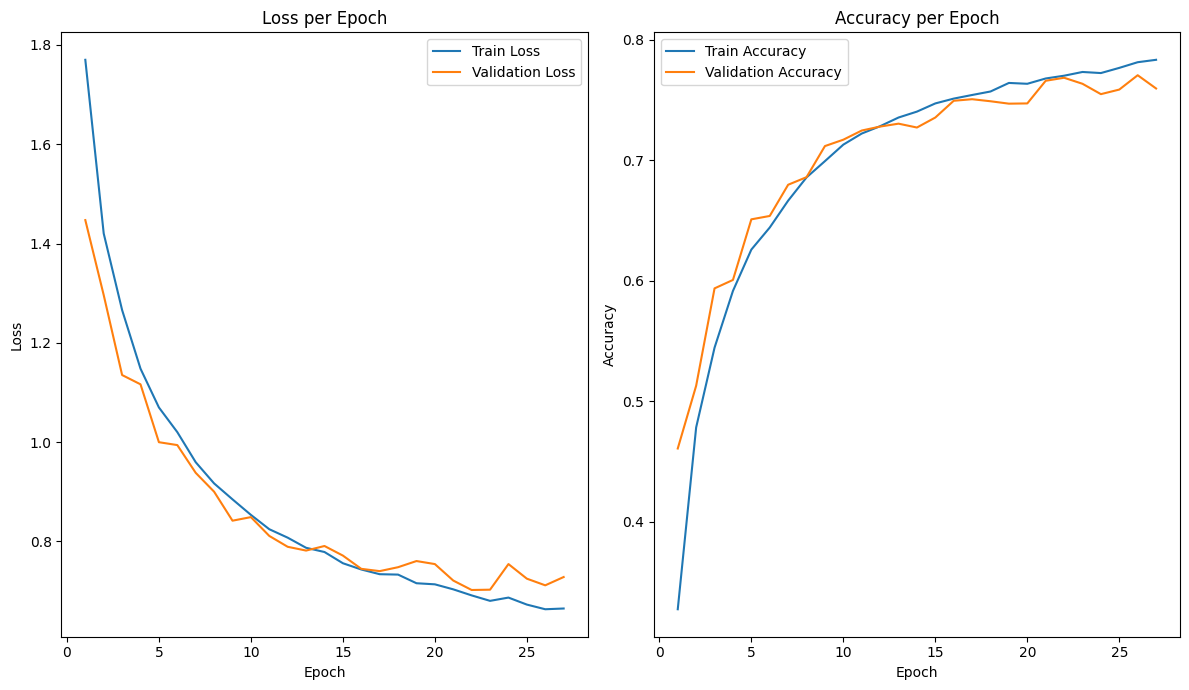

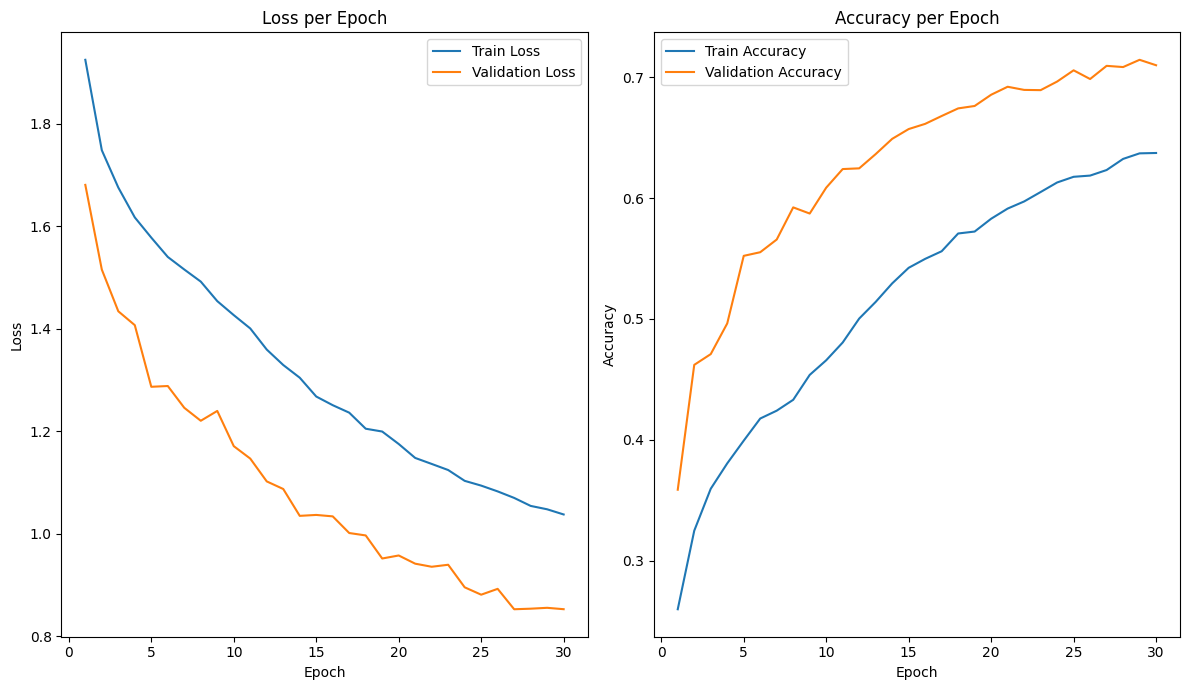

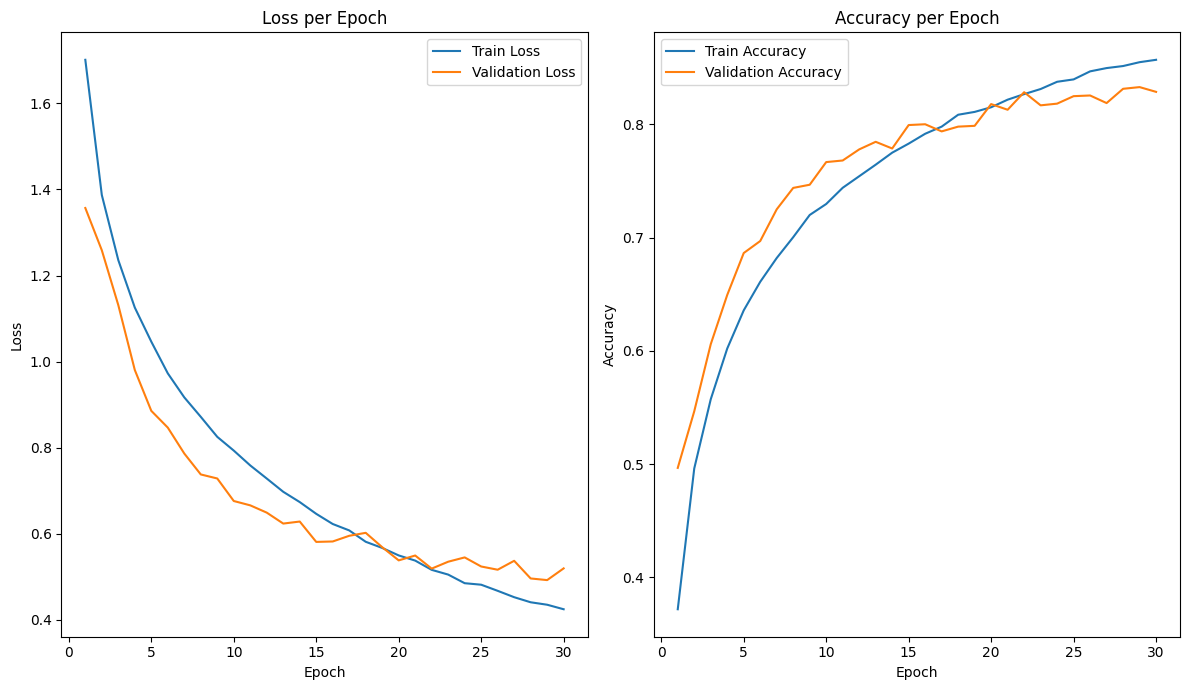

In [ ]:
plot_training_history(train_losses_Alex, val_losses_Alex, train_accuracies_Alex, val_accuracies_Alex)
plot_training_history(train_losses_CNN, val_losses_CNN, train_accuracies_CNN, val_accuracies_CNN)
plot_training_history(train_losses_CNNNew, val_losses_CNNNew, train_accuracies_CNNNew, val_accuracies_CNNNew)

In [ ]:
evaluate_model(AlexNet, testloader, device, classes)
evaluate_model(CNNCifar, testloader, device, classes)
evaluate_model(CNNNew, testloader, device, classes)


Accuracy model alexNet on the 10000 test images: 77.70%
Accuracy of plane: 78.30%
Accuracy of car: 89.70%
Accuracy of bird: 71.40%
Accuracy of cat: 57.60%
Accuracy of deer: 76.80%
Accuracy of dog: 73.40%
Accuracy of frog: 78.60%
Accuracy of horse: 82.10%
Accuracy of ship: 87.10%
Accuracy of truck: 82.00%


Accuracy model CNN on the 10000 test images: 72.34%
Accuracy of plane: 80.60%
Accuracy of car: 92.60%
Accuracy of bird: 59.40%
Accuracy of cat: 35.10%
Accuracy of deer: 62.00%
Accuracy of dog: 69.60%
Accuracy of frog: 85.10%
Accuracy of horse: 72.70%
Accuracy of ship: 86.90%
Accuracy of truck: 79.40%


Accuracy model CNN2 on the 10000 test images: 84.94%
Accuracy of plane: 86.40%
Accuracy of car: 93.90%
Accuracy of bird: 73.40%
Accuracy of cat: 74.50%
Accuracy of deer: 86.20%
Accuracy of dog: 75.50%
Accuracy of frog: 92.80%
Accuracy of horse: 87.90%
Accuracy of ship: 92.00%
Accuracy of truck: 86.80%




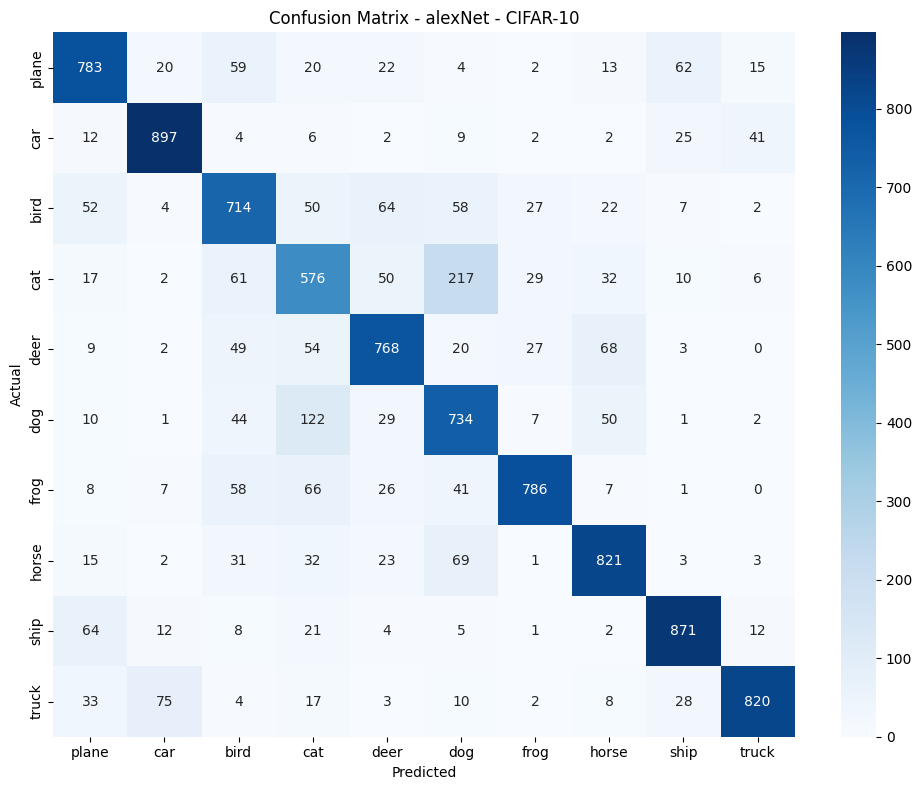

Accuracy             0.777000
Precision (macro)    0.781340
Recall (macro)       0.777000
F1 Score (macro)     0.778149
dtype: float64


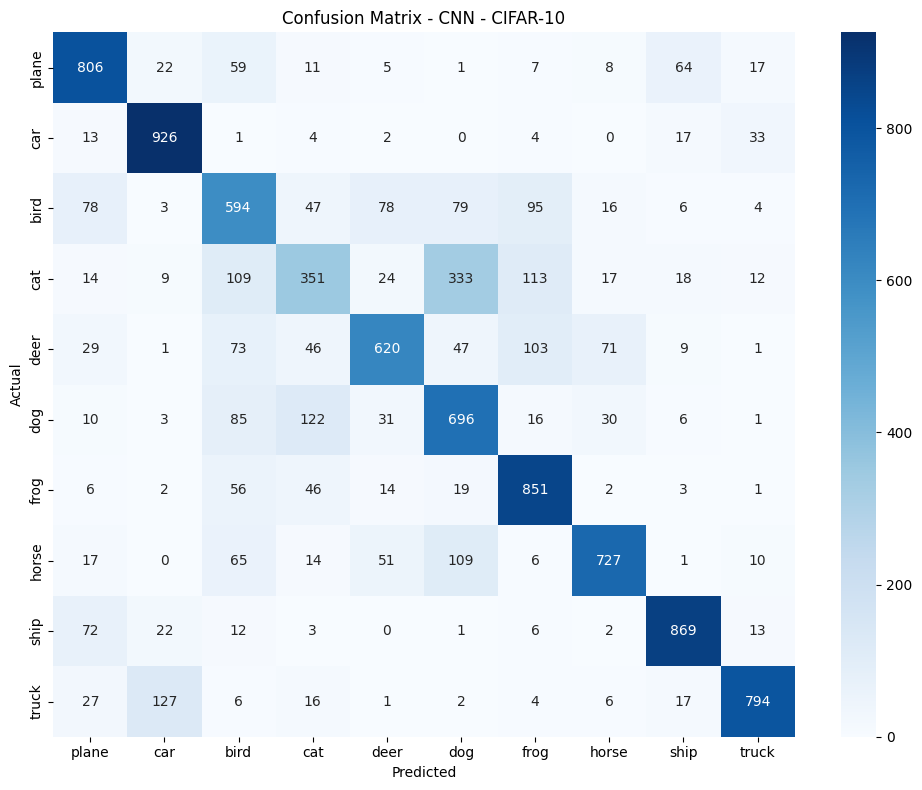

Accuracy             0.723400
Precision (macro)    0.725581
Recall (macro)       0.723400
F1 Score (macro)     0.719334
dtype: float64


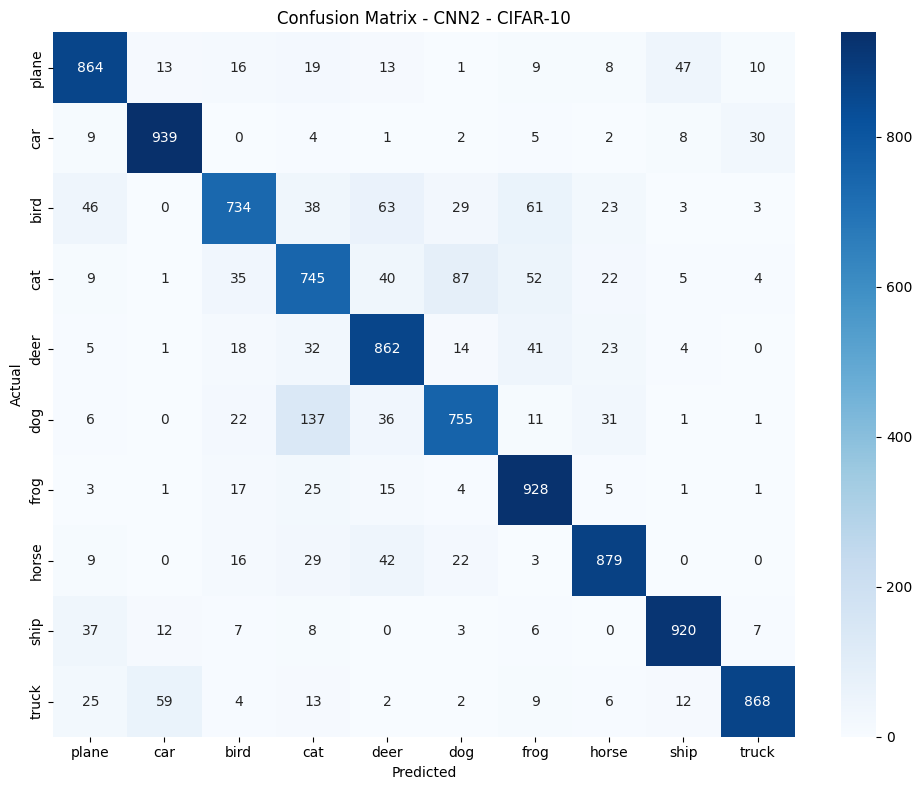

Accuracy             0.849400
Precision (macro)    0.850969
Recall (macro)       0.849400
F1 Score (macro)     0.849044
dtype: float64


In [ ]:
plot_confusion_matrix(AlexNet, testloader, device, classes)
plot_confusion_matrix(CNNCifar, testloader, device, classes)
plot_confusion_matrix(CNNNew, testloader, device, classes)

# Analisis Feature Maps dengan Grad-CAM

In [ ]:
def visualize_gradcam(model, layers, dataset, idx, classes=None):
    """
    Visualisasikan Grad-CAM untuk gambar dari dataset pada layer-layer yang ditentukan.

    Args:
        model: CNN model (harus memiliki .features jika menggunakan indeks layer).
        layers: List indeks layer convolutional (misalnya [0, 4, 8]).
        dataset: Dataset berformat (image, label) seperti torchvision.datasets.
        idx: Indeks gambar dari dataset.
        classes: List nama-nama kelas. Default CIFAR-10 jika None.
    """

    model.eval()
    device = next(model.parameters()).device

    # Ambil satu gambar dan label dari dataset
    img_tensor, label = dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # Untuk show_cam_on_image
    img_for_vis = img_tensor.permute(1, 2, 0).numpy()
    img_for_vis = (img_for_vis * 0.5) + 0.5  # asumsikan normalisasi -1..1
    img_for_vis = np.clip(img_for_vis, 0, 1)

    output = model(input_tensor)
    predicted_class = output.argmax().item()

    if classes is None:
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    cam_results = [("Original", img_for_vis)]

    for i, layer in enumerate(layers):
        target_layers = [model.features[layer]]
        cam = GradCAM(model=model, target_layers=target_layers)
        targets = [ClassifierOutputTarget(predicted_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        cam_img = show_cam_on_image(img_for_vis, grayscale_cam[0], use_rgb=True)
        cam_results.append((f'Conv {i+1}', cam_img))

    total_images = len(cam_results)

    # Plot dalam 1 baris
    plt.figure(figsize=(4* total_images, 4 ))
    for i, (title, vis_img) in enumerate(cam_results):
        plt.subplot( 1, total_images, i + 1)
        plt.imshow(vis_img)
        plt.axis('off')
        plt.title(title)

    model_name = model.__class__.__name__
    plt.suptitle(f'Model: {model_name} | True: {classes[label]} | Pred: {classes[predicted_class]}', fontsize=14)
    plt.tight_layout(
        rect=[0, 0, 1, 0.98]
        )
    plt.show()

def get_misclassified_indices(model, dataset, device):
    misclassified_indices = []
    model.eval()  # Set model ke mode evaluasi

    with torch.no_grad():
        for idx in range(len(dataset)):
            image, label = dataset[idx]  # label adalah int biasa
            image = image.to(device)

            output = model(image.unsqueeze(0))  # Tambah dimensi batch
            pred = output.argmax(dim=1).item()

            if pred != label:
                misclassified_indices.append(idx)

    return misclassified_indices

In [ ]:
test_sets_idx = {}
idx_img = 0
for img, label in testset:
    if classes[label] not in test_sets_idx:
        test_sets_idx[classes[label]] = [idx_img]
    else:
        test_sets_idx[classes[label]].append(idx_img)
    idx_img += 1

## Alex_Net

In [ ]:
summary(AlexNet)

Layer (type:depth-idx)                   Param #
alexNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       110,784
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       663,936
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       884,992
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      590,080
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─Sequential: 1-2                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      4,195,328
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                      

In [ ]:
Alex_miss_idx = get_misclassified_indices(AlexNet, testset, device)
print(f"banyak data yang salah diprediksi oleh AlexNet: {len(Alex_miss_idx)}")

Alex_miss_classes_idx = {}
for idx in Alex_miss_idx:
    if classes[testset[idx][1]] not in Alex_miss_classes_idx:
        Alex_miss_classes_idx[classes[testset[idx][1]]] = [idx]
    else:
        Alex_miss_classes_idx[classes[testset[idx][1]]].append(idx)

sum([len(i) for i in Alex_miss_classes_idx.values()])

banyak data yang salah diprediksi oleh AlexNet: 2230


2230

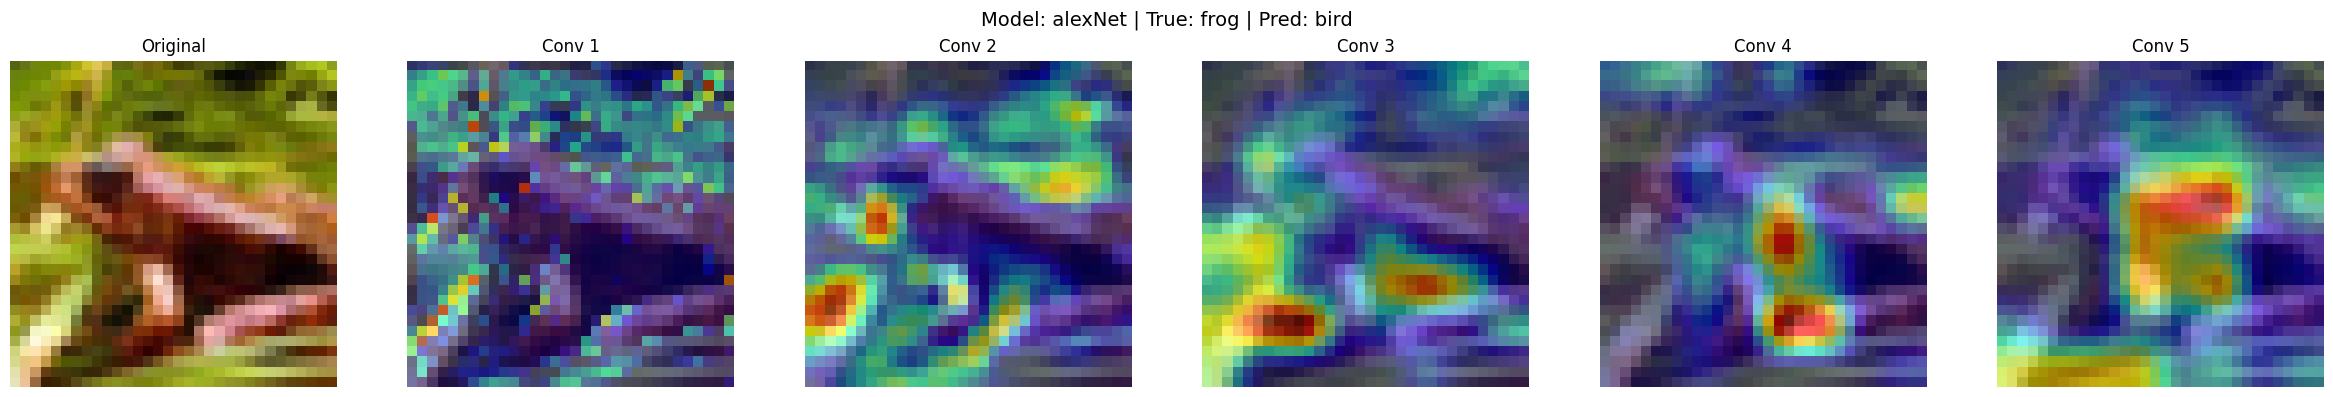

In [ ]:
idx = Alex_miss_idx[222]
visualize_gradcam(AlexNet, layers=[0, 3, 6, 8, 10], dataset=testset, idx=idx)

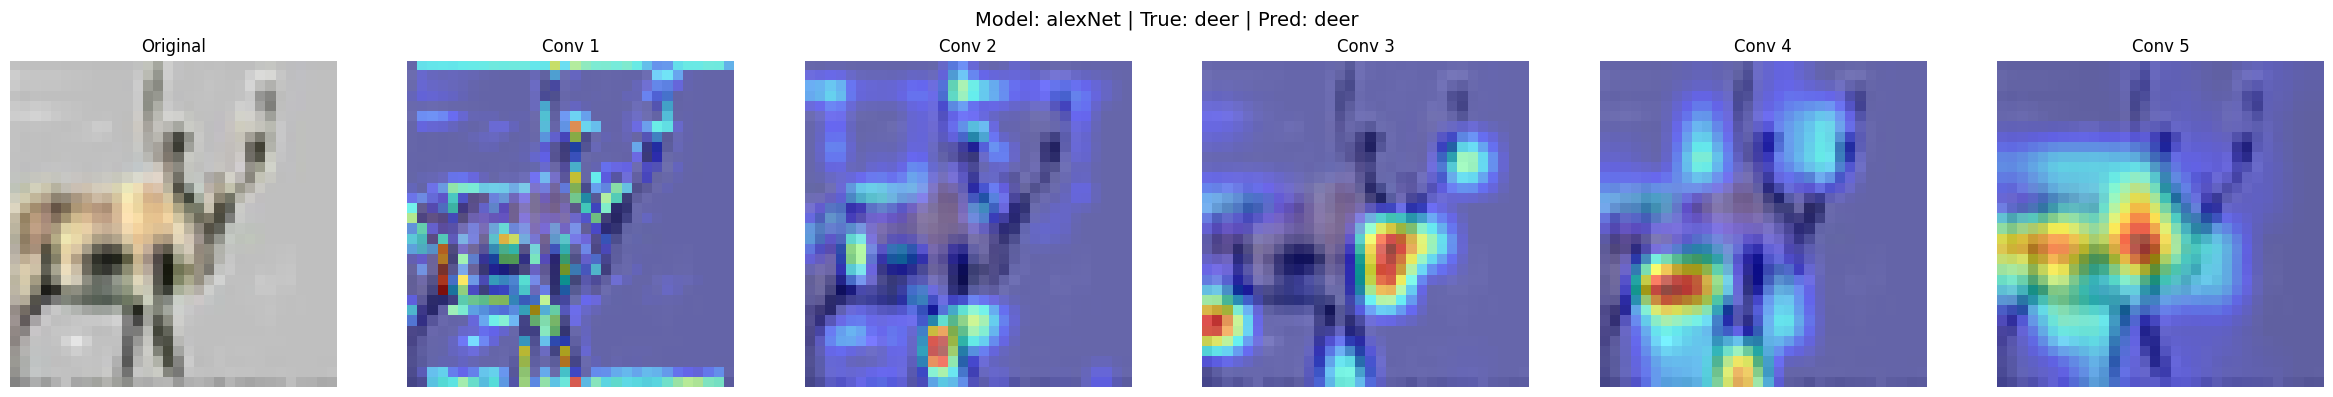

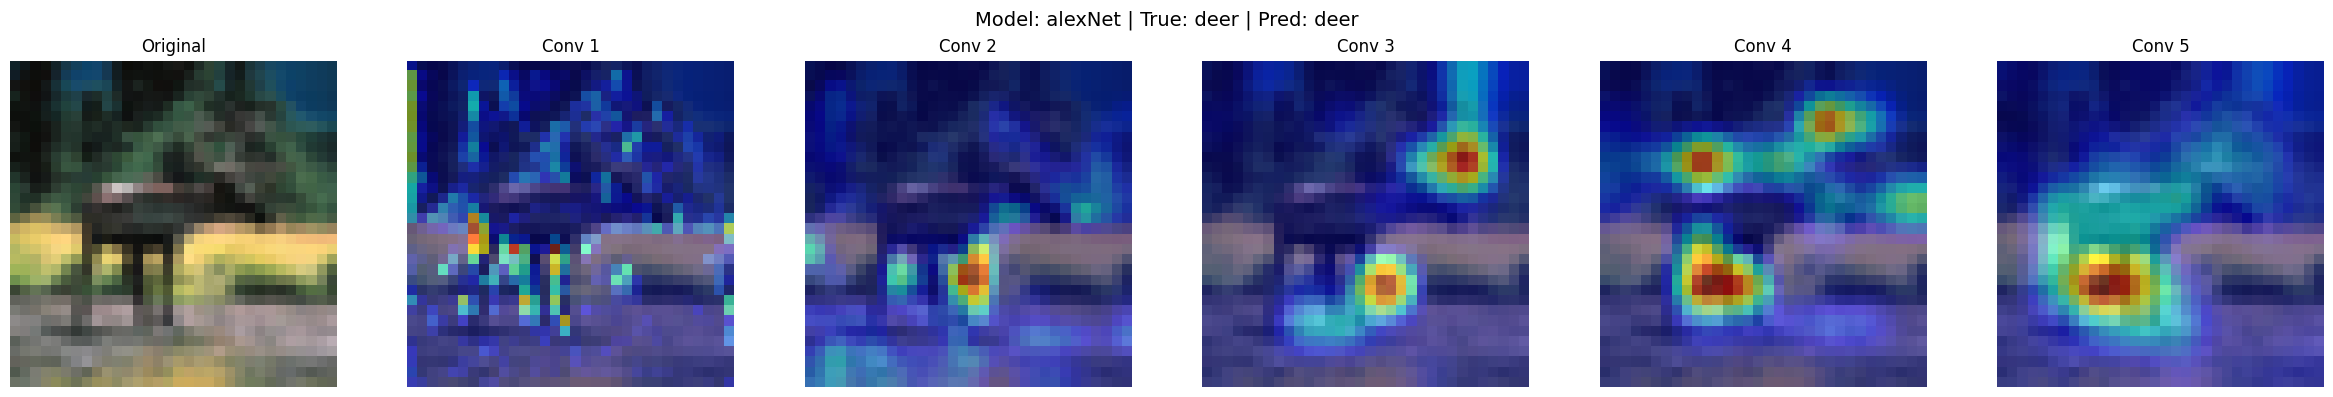

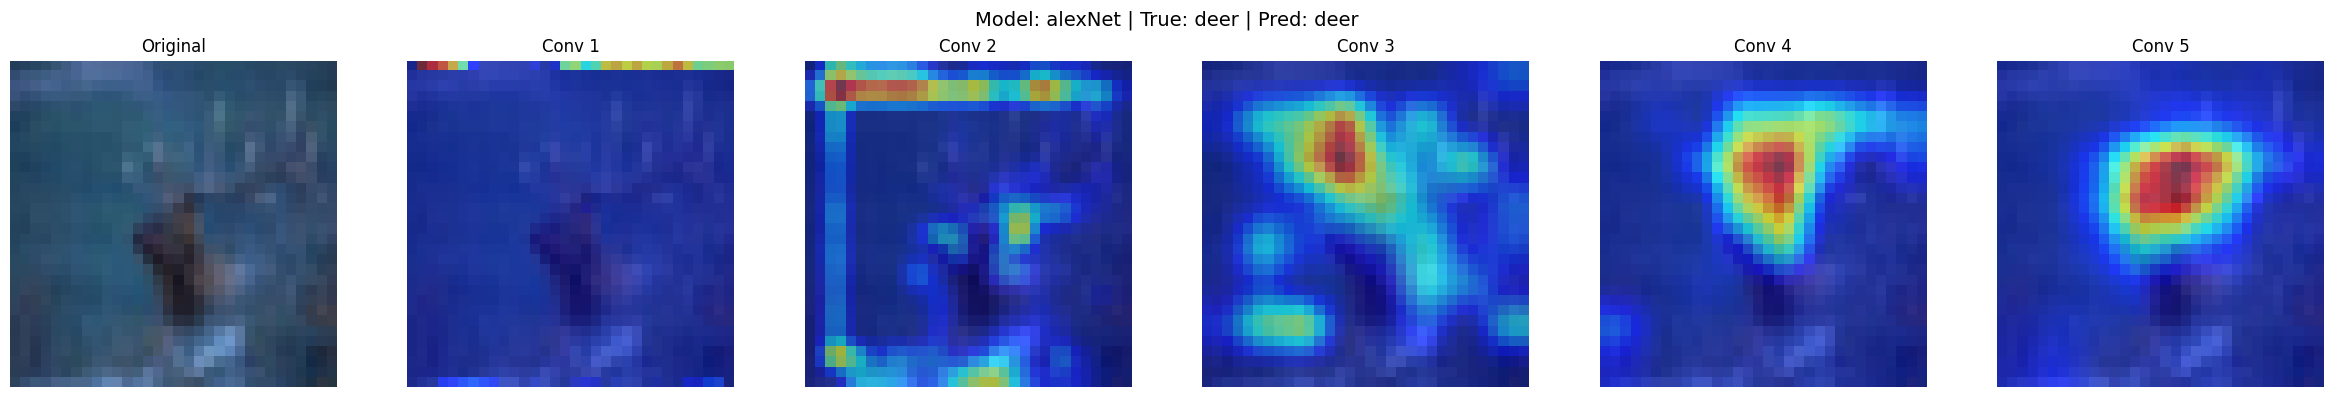

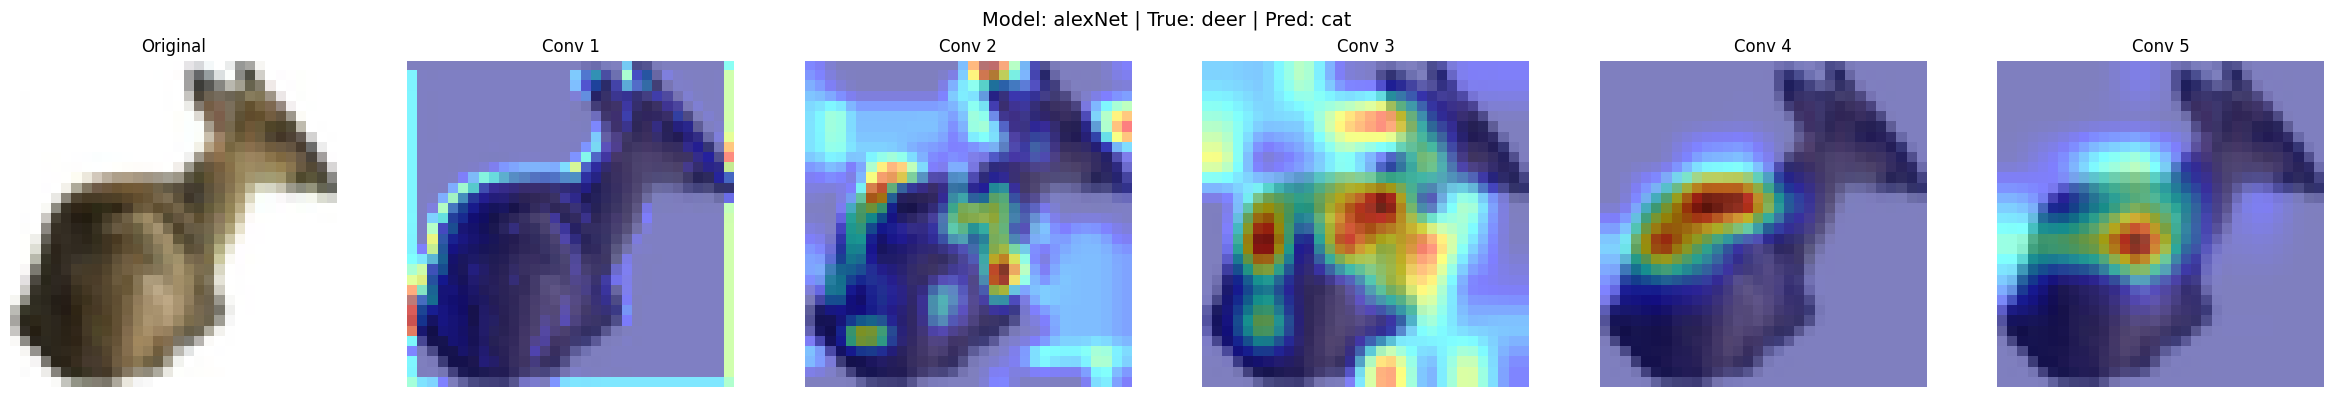

In [ ]:
for i in list(set(test_sets_idx['deer']) - set(Alex_miss_classes_idx['deer']))[3:6] + [Alex_miss_classes_idx['deer'][5]]:
    visualize_gradcam(AlexNet, layers=[0, 3, 6, 8, 10], dataset=testset, idx=i)

## CNN1

In [ ]:
summary(CNNCifar)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       18,496
│    └─BatchNorm2d: 2-5                  128
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Dropout: 2-8                      --
│    └─Conv2d: 2-9                       73,856
│    └─BatchNorm2d: 2-10                 256
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
│    └─Dropout: 2-13                     --
├─Sequential: 1-2                        --
│    └─Flatten: 2-14                     --
│    └─Linear: 2-15                      2,097,408
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                      2,570
Total 

In [ ]:
CNN1_miss_idx = get_misclassified_indices(CNNCifar, testset, device)
print(f"banyak data yang salah diprediksi oleh CNN1: {len(CNN1_miss_idx)}")

CNN1_miss_classes_idx = {}
for idx in CNN1_miss_idx:
    if classes[testset[idx][1]] not in CNN1_miss_classes_idx:
        CNN1_miss_classes_idx[classes[testset[idx][1]]] = [idx]
    else:
        CNN1_miss_classes_idx[classes[testset[idx][1]]].append(idx)

sum([len(i) for i in CNN1_miss_classes_idx.values()])

banyak data yang salah diprediksi oleh CNN1: 2766


2766

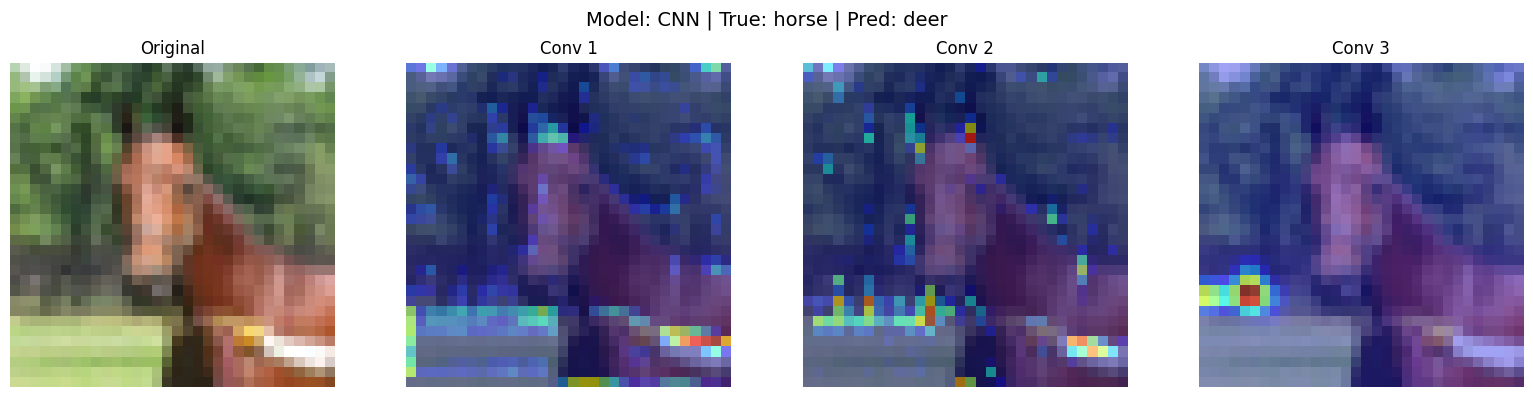

In [ ]:
idx = CNN1_miss_idx[123]
visualize_gradcam(CNNCifar, layers=[0, 3, 8], dataset=testset, idx=idx)

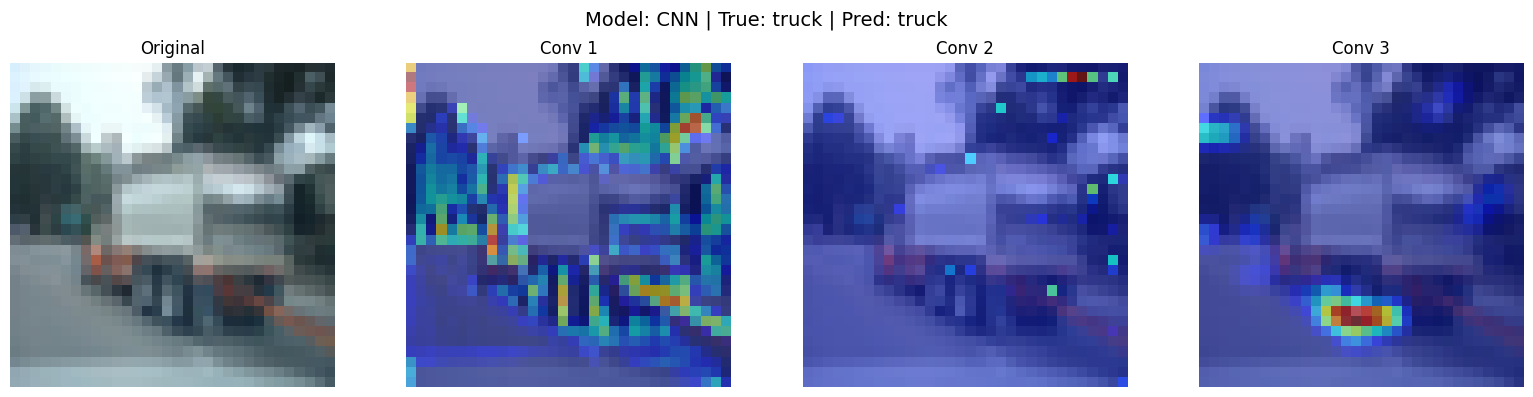

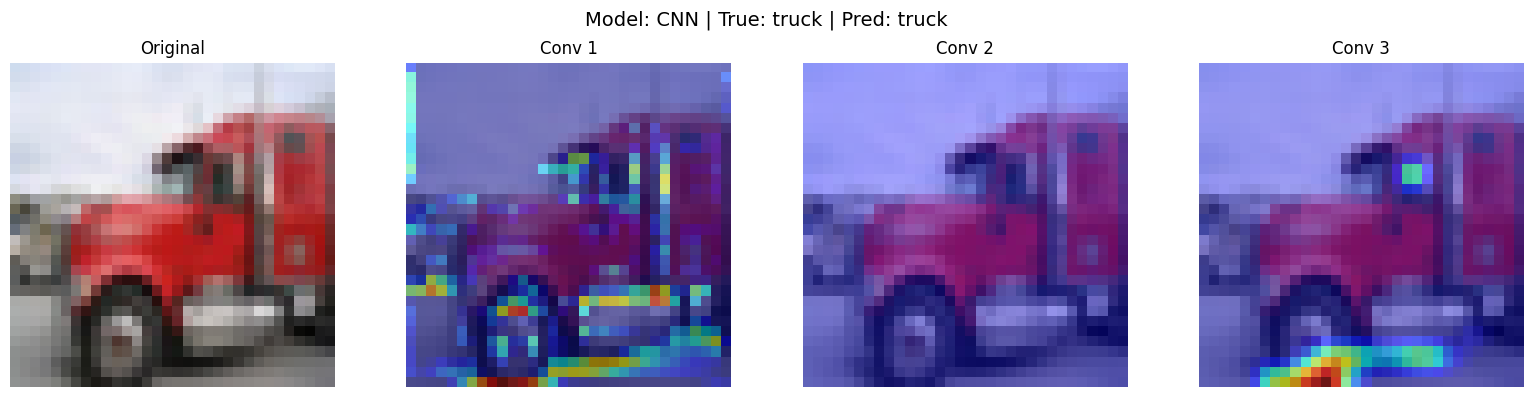

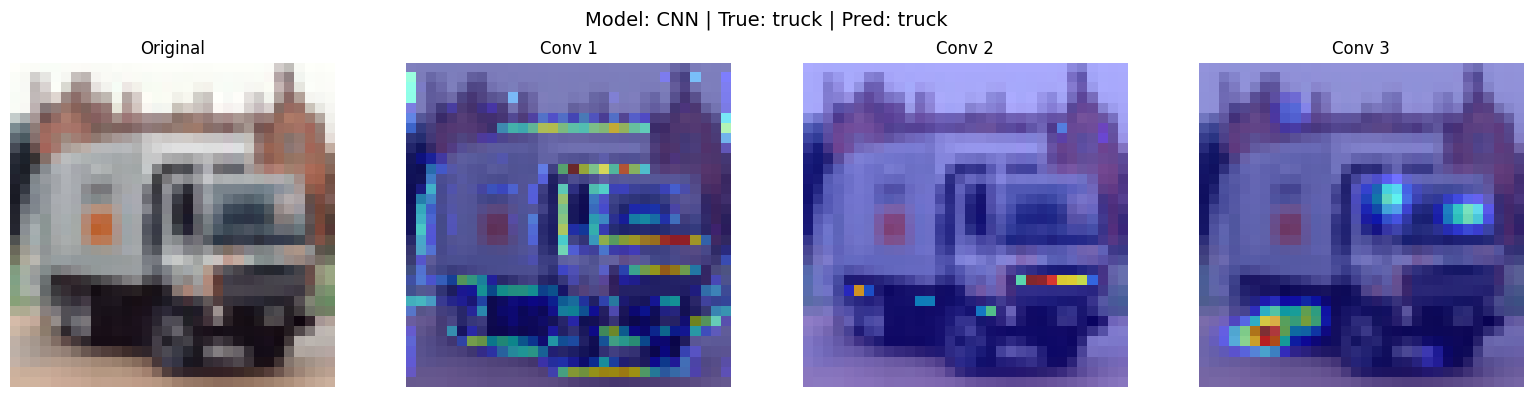

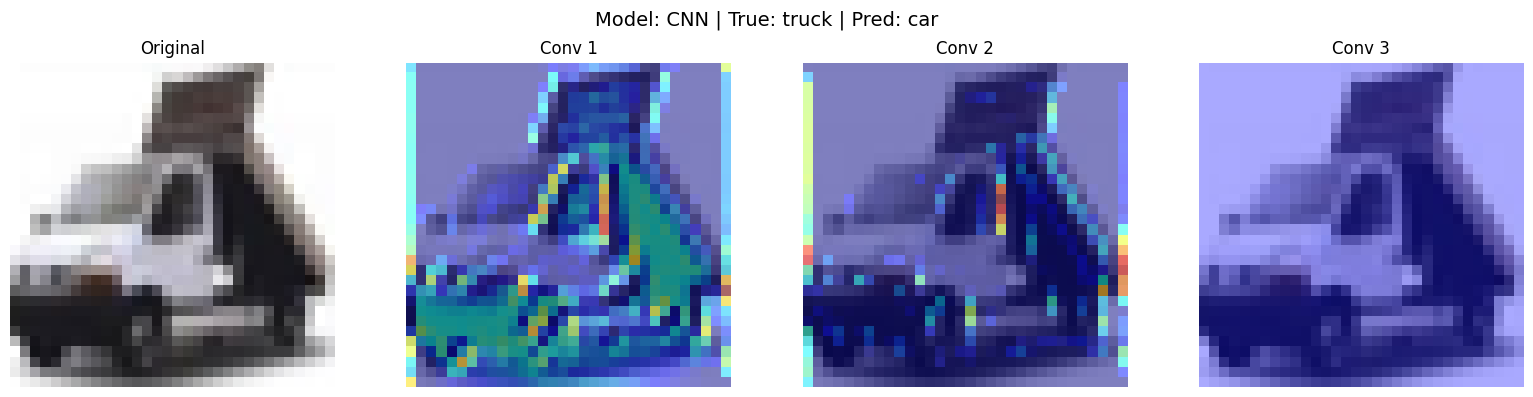

In [ ]:
for i in list(set(test_sets_idx['truck']) - set(CNN1_miss_classes_idx['truck']))[:3] + [CNN1_miss_classes_idx['truck'][7]]:
    visualize_gradcam(CNNCifar, layers=[0, 3, 8], dataset=testset, idx=i)

## CNN2

In [ ]:
summary(CNNNew)

Layer (type:depth-idx)                   Param #
CNN2                                     --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       73,856
│    └─BatchNorm2d: 2-6                  256
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       295,168
│    └─BatchNorm2d: 2-10                 512
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
├─Sequential: 1-2                        --
│    └─Flatten: 2-13                     --
│    └─Linear: 2-14                      2,097,664
│    └─ReLU: 2-15                        --
│    └─Dropout: 2-16                     --
│    └─Linear: 2-17                      5,130
Total params: 2,474,506
Trainable params: 2,47

In [ ]:
CNN2_miss_idx = get_misclassified_indices(CNNNew, testset, device)
print(f"banyak data yang salah diprediksi oleh CNN2: {len(CNN2_miss_idx)}")

CNN2_miss_classes_idx = {}
for idx in CNN2_miss_idx:
    if classes[testset[idx][1]] not in CNN2_miss_classes_idx:
        CNN2_miss_classes_idx[classes[testset[idx][1]]] = [idx]
    else:
        CNN2_miss_classes_idx[classes[testset[idx][1]]].append(idx)

sum([len(i) for i in CNN2_miss_classes_idx.values()])

banyak data yang salah diprediksi oleh CNN2: 1506


1506

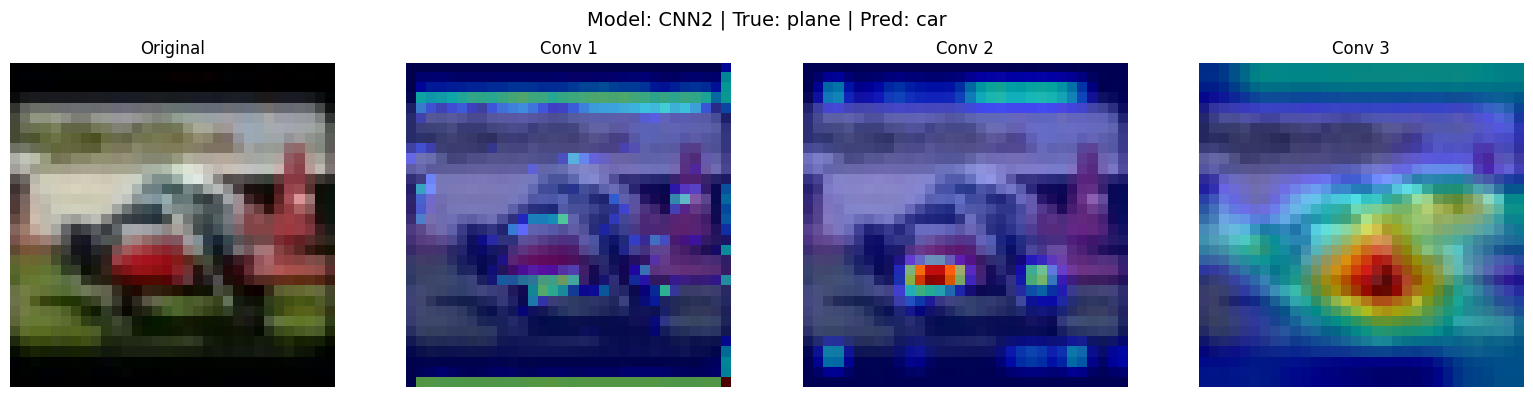

In [ ]:
idx = CNN2_miss_idx[465]

visualize_gradcam(CNNNew, layers=[0, 4, 8,], dataset=testset, idx=idx)

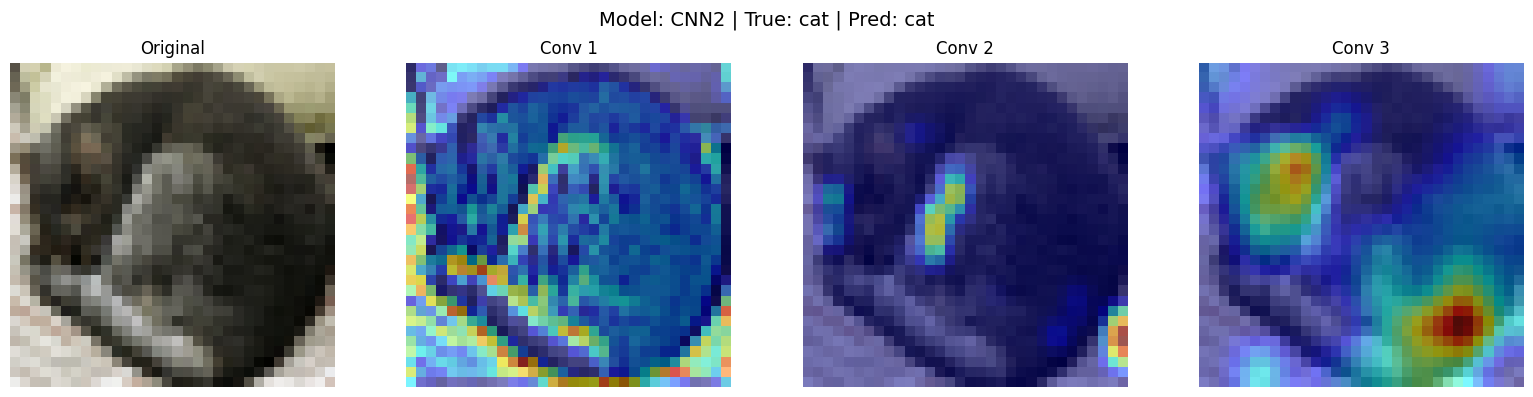

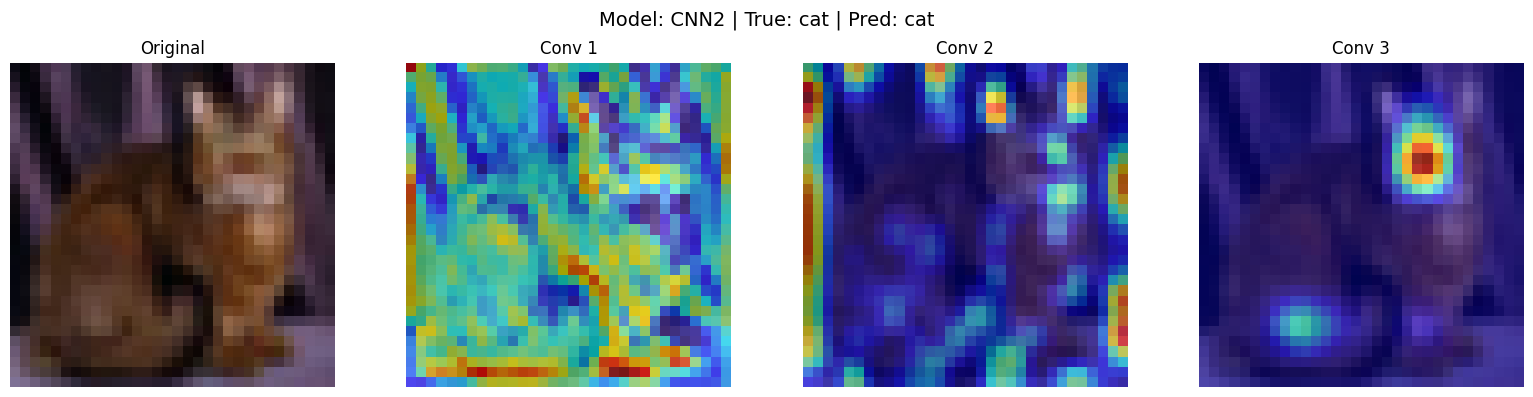

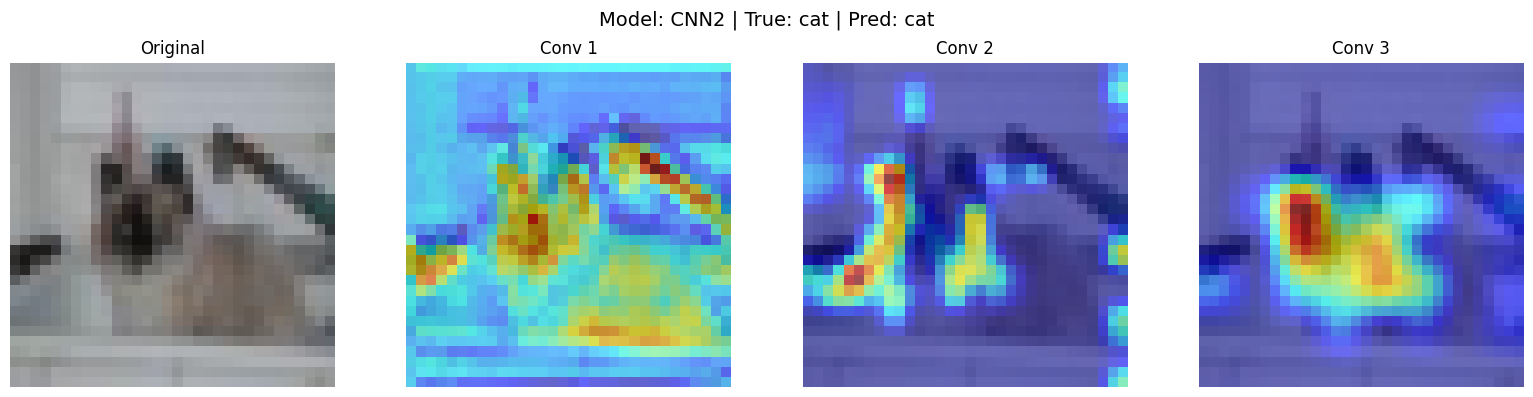

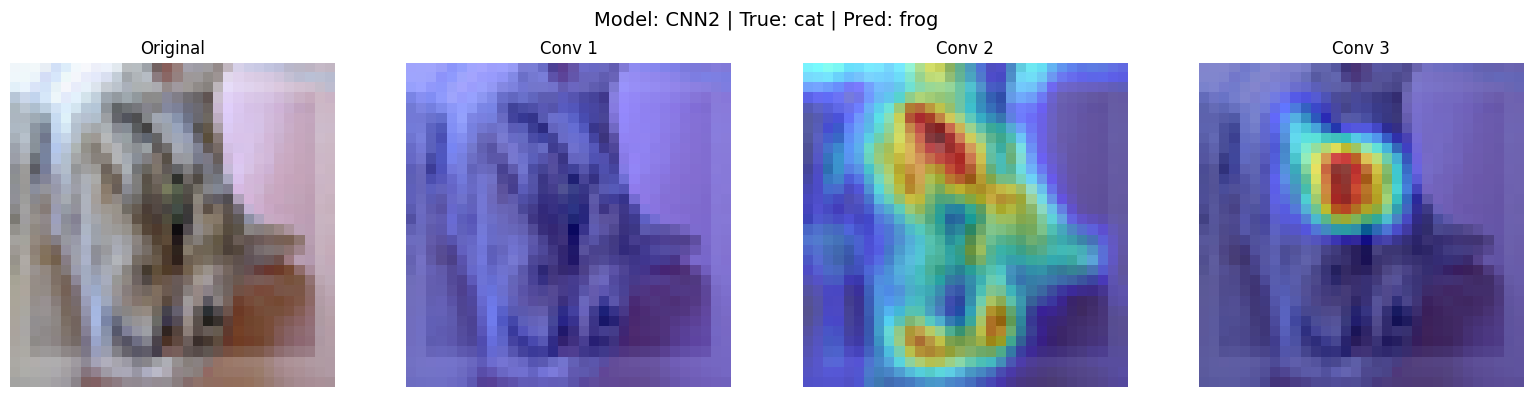

In [ ]:
for i in list(set(test_sets_idx['cat']) - set(CNN2_miss_classes_idx['cat']))[13:16] + [CNN2_miss_classes_idx['cat'][9]]:
    visualize_gradcam(CNNNew, layers=[0, 4, 8], dataset=testset, idx=i)

## Melihat data-data yang salah diprediksi oleh ke-tiga model

In [ ]:
false_idx = list(set(Alex_miss_idx) & set(CNN1_miss_idx) & set(CNN2_miss_idx))

CNN2_Right_idx = list((set(CNN1_miss_idx) & set(Alex_miss_idx)) - set(CNN2_miss_idx))

len(false_idx), len(CNN2_Right_idx)

(839, 654)

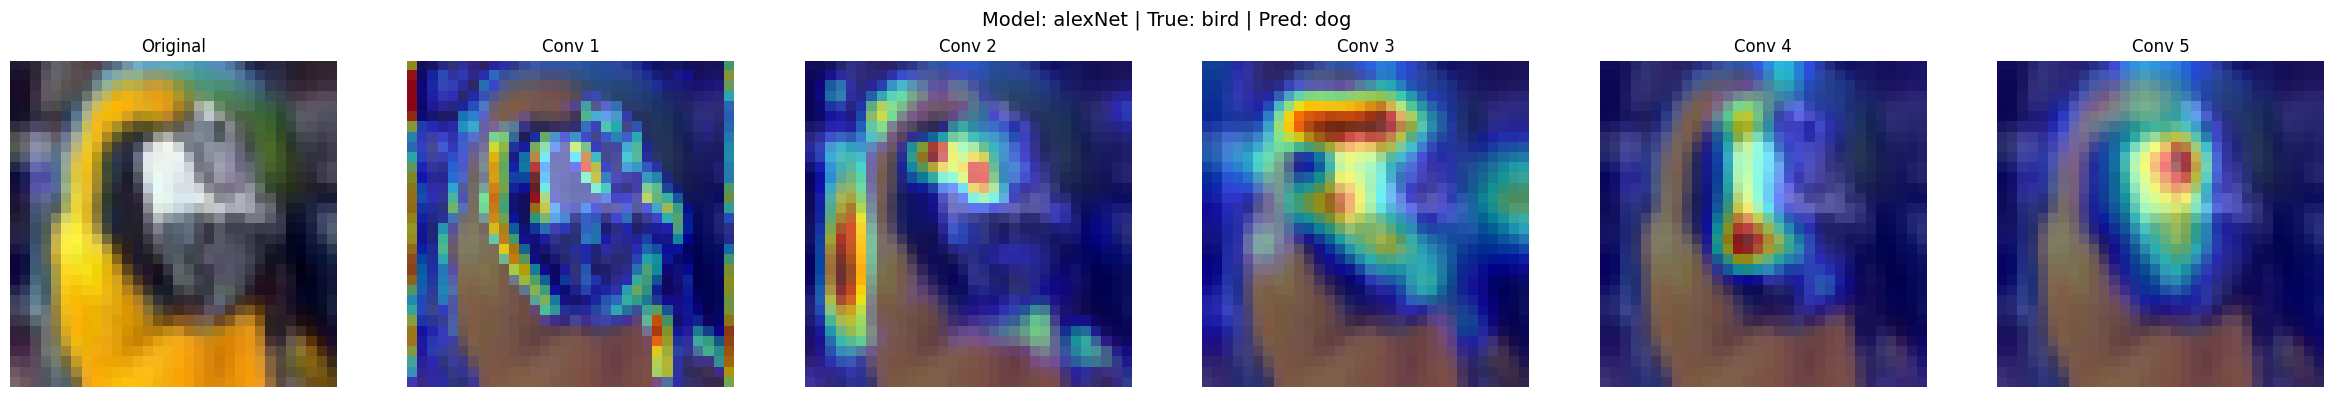

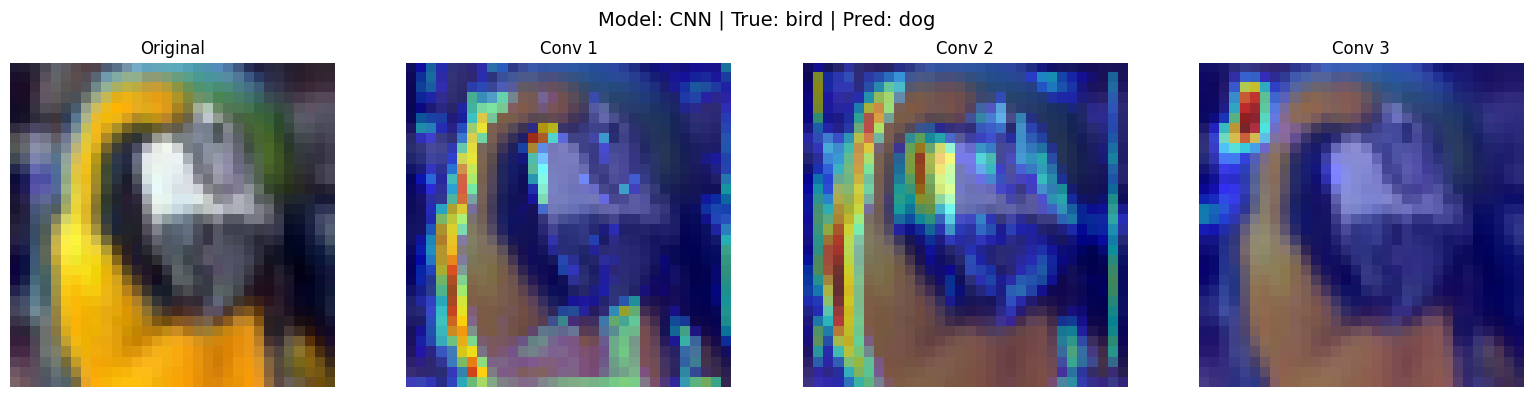

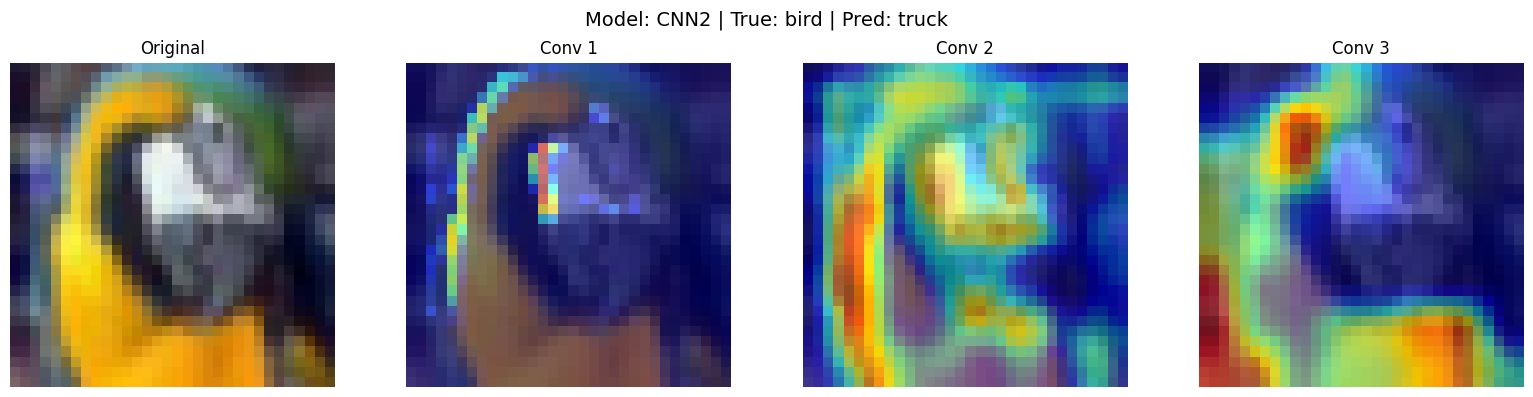

In [ ]:
idx = false_idx[69]

visualize_gradcam(AlexNet, layers=[0, 3, 6, 8, 10], dataset=testset, idx=idx)
visualize_gradcam(CNNCifar, layers=[0, 3, 8], dataset=testset, idx=idx)
visualize_gradcam(CNNNew, layers=[0, 4, 8,], dataset=testset, idx=idx)

## Melihat data-data yang yang Benar diprediksi oleh cnn-2 namun salah diprediksi oleh cnn-1 dan alexnet

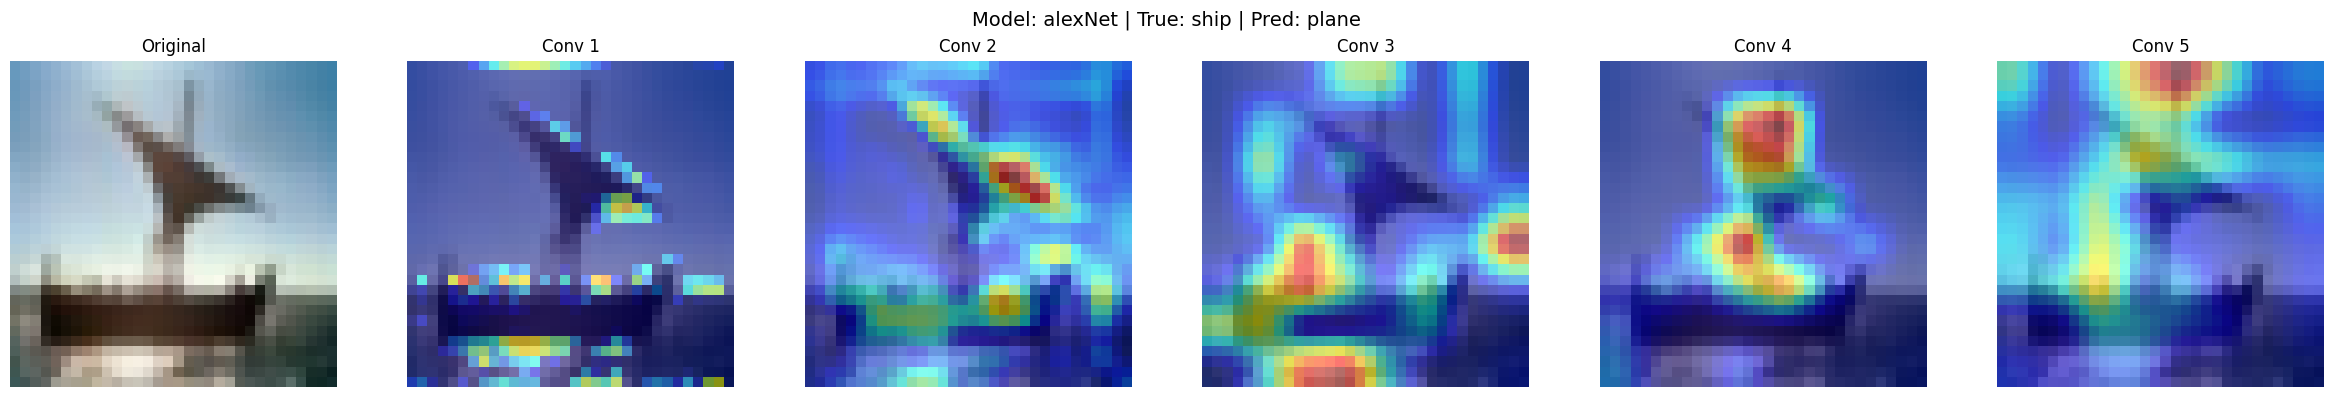

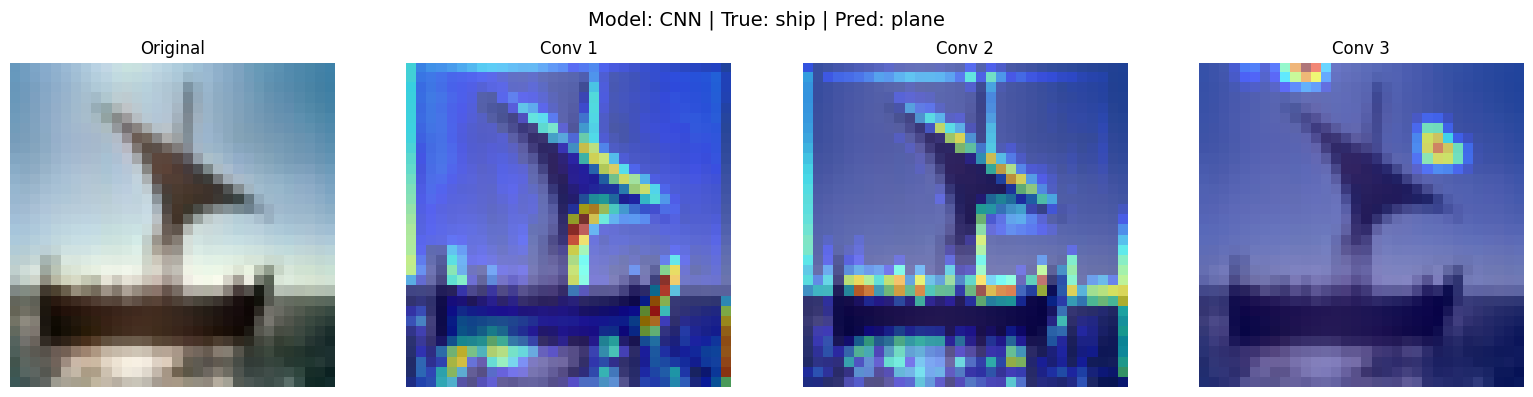

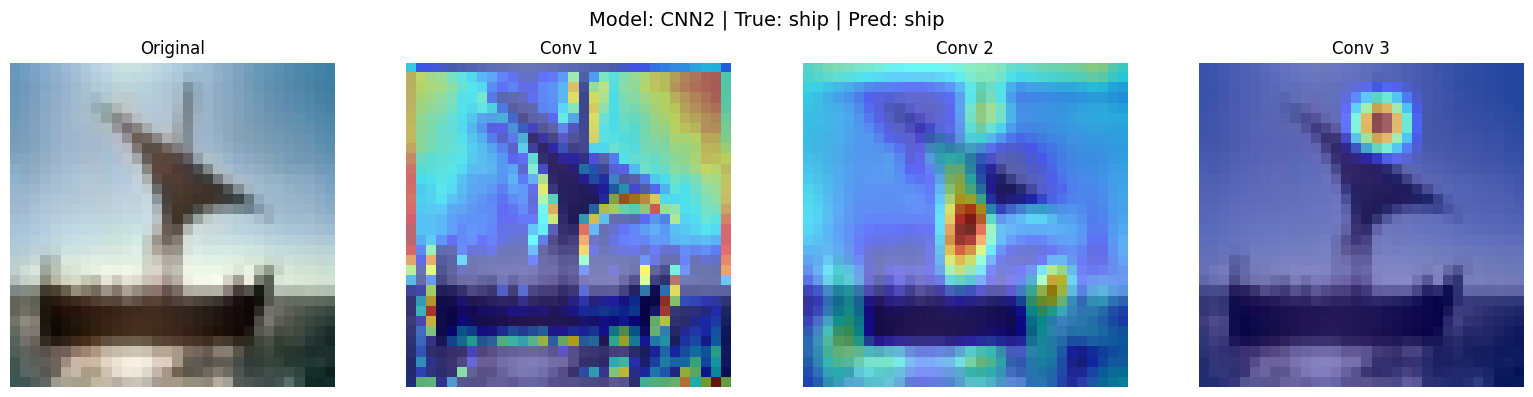

In [ ]:
idx = CNN2_Right_idx[45]

visualize_gradcam(AlexNet, layers=[0, 3, 6, 8, 10], dataset=testset, idx=idx)
visualize_gradcam(CNNCifar, layers=[0, 3, 8], dataset=testset, idx=idx)
visualize_gradcam(CNNNew, layers=[0, 4, 8,], dataset=testset, idx=idx)